# Pneumonia X-ray case, image recognition using CNN.

# Overview
With the increasing number of pneumonia cases during COVID hospitals are overwhelmed with additional work. Some of the methods that are used to diagnosed COVID is by making X rays of chrest. I was hired by a local hospital to create a model that can automatically classify person on having or not pneumonia based on X-ray. This system should have high accuracy and high recall.

To acheive my goal, I used different DeepLearn techniques including CNN and pretrained CNN. 


# Business Understanding
Our stakeholder wants to have model that can be reliable in predicting when person have pneumonia.

# Data

1) Chest X-Ray Images. Year: 2018 
Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Large Dataset of Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images”, Mendeley Data, V3, doi: 10.17632/rscbjbr9sj.3

https://data.mendeley.com/datasets/rscbjbr9sj/3


# Metrics
#### Our project will answer following question:
Can we predict people with pneumonia based on their chrest X-ray?

#### Hypothesis:
H0 - Person has pneumonia

HA - There is statisticaly significant proof that the preson doesnt' have pneumonia

#### TP, TN, FP, FN definition
TP - we predicted pneumonia and it actually exist.

TN - we predicted that person didn't have pneumonia and the person actually didn't have it.

FP - We predicted pneumonia but there was no pneumonia in real life.

FN - We predicted that there is no pneumonia but it actually existed.


#### Metrics used  
To compare models we will focus on 2 major metrics:

Recall - Health of people is our priority, we will be focused to minimize FN.
##### Business requirement: our system should have at least 95% recall. 

Accuracy - how good we can predict TP and TN. General metrics that will show model performance.




# Data Understanding
#### Sources of data:
1) Chest X-Ray Images. Year: 2018 
Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Large Dataset of Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images”, Mendeley Data, V3, doi: 10.17632/rscbjbr9sj.3

https://data.mendeley.com/datasets/rscbjbr9sj/3

#### Main dataset contains the following images:
Train set:

There are 1349 normal images, image name example, NORMAL-2552119-0002.jpeg

There are 4489 pneumonia images, image name example, BACTERIA-4038442-0001.jpeg

Test set:

There are 234 normal images, image name example, NORMAL-8698006-0001.jpeg

There are 390 pneumonia images, image name example, VIRUS-2040583-0001.jpeg


# Data Cleaning
### Importing required modules

In [1]:
# Work with data
import pandas as pd
import numpy as np
from scipy import stats as stats

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

#Modeling


from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, roc_curve, plot_roc_curve, roc_auc_score, accuracy_score, recall_score, f1_score

# Keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from keras.regularizers import l2
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import RMSprop

#Other
import pickle
import time
import gzip
import os, shutil 
from zipfile import ZipFile
import scipy
from PIL import Image
from scipy import ndimage
import itertools

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning, FitFailedWarning
simplefilter(action='ignore', category= FutureWarning)
simplefilter(action='ignore', category= ConvergenceWarning)
simplefilter(action='ignore', category= FitFailedWarning)
simplefilter(action='ignore', category= UserWarning)





np.random.seed(123)

  




### Data preparation

Below we create three objects representing the existing directories: `data/normal/` as `data_normal_dir` and `data/pneumonia/` as `data_pneumonia_dir`, `data/test/normal/` as `test/normal` and `data/test/pneumonia/` as `test/pneumonia`. We will create a new directory `split/` as `new_dir`, where we will split the dataset in three groups (or three subdirectories): `train`, `test`, and `validation`, each containing `normal` and `pneumonia` subfolders. The final desired structure is represented below: 

![title](images/folder_structure.png)

In [2]:
data_normal_dir = 'data/normal/'
data_pneumonia_dir = 'data/pneumonia/'
new_dir = 'data/split/'
data_test_normal_dir = 'data/test/normal/'
data_test_pneumonia_dir = 'data/test/pneumonia/'

In [3]:
# Train set
imgs_normal = [file for file in os.listdir(data_normal_dir) if file.endswith('.jpeg')]
imgs_pneumonia = [file for file in os.listdir(data_pneumonia_dir) if file.endswith('.jpeg')]
# Test set
imgs_normal_test = [file for file in os.listdir(data_test_normal_dir) if file.endswith('.jpeg')]
imgs_pneumonia_test = [file for file in os.listdir(data_test_pneumonia_dir) if file.endswith('.jpeg')]

In [4]:
os.listdir(data_normal_dir)[0]

'NORMAL-2552119-0002.jpeg'

In [5]:
print("Train set:")
print('There are', len(imgs_normal), 'normal images, image name example,',os.listdir(data_normal_dir)[0])
print('There are', len(imgs_pneumonia), 'pneumonia images, image name example,',os.listdir(data_pneumonia_dir)[0])
print("Test set:")
print('There are', len(imgs_normal_test), 'normal images, image name example,',os.listdir(data_test_normal_dir)[0])
print('There are', len(imgs_pneumonia_test), 'pneumonia images, image name example,',os.listdir(data_test_pneumonia_dir)[0])


Train set:
There are 1349 normal images, image name example, NORMAL-2552119-0002.jpeg
There are 4489 pneumonia images, image name example, BACTERIA-4038442-0001.jpeg
Test set:
There are 234 normal images, image name example, NORMAL-8698006-0001.jpeg
There are 390 pneumonia images, image name example, VIRUS-2040583-0001.jpeg


Make new split directory

In [6]:
os.mkdir(new_dir)

Create new directories

In [7]:
# Define path
train_folder = os.path.join(new_dir, 'train')
train_normal = os.path.join(train_folder, 'normal')
train_pneumonia = os.path.join(train_folder, 'pneumonia')

test_folder = os.path.join(new_dir, 'test')
test_normal = os.path.join(test_folder, 'normal')
test_pneumonia = os.path.join(test_folder, 'pneumonia')

val_folder = os.path.join(new_dir, 'validation')
val_normal = os.path.join(val_folder, 'normal')
val_pneumonia = os.path.join(val_folder, 'pneumonia')

In [8]:
# Check that path is ok
train_pneumonia

'data/split/train/pneumonia'

In [9]:
# Create directories
os.mkdir(test_folder)
os.mkdir(test_normal)
os.mkdir(test_pneumonia)

os.mkdir(train_folder)
os.mkdir(train_normal)
os.mkdir(train_pneumonia)

os.mkdir(val_folder)
os.mkdir(val_normal)
os.mkdir(val_pneumonia)

Copy images

In [10]:
# Define validation set.
validation_ratio = 0.15

In [11]:
# Setting size of validation set
val_set_norm = int(len(os.listdir(data_normal_dir))*validation_ratio)
val_set_pneumo = int(len(os.listdir(data_pneumonia_dir))*validation_ratio)

In [12]:
val_set_pneumo

673

In [13]:
# train normal
imgs_train_norm = imgs_normal[:len(os.listdir(data_normal_dir))-val_set_norm]
for img in imgs_train_norm:
    origin = os.path.join(data_normal_dir, img)
    destination = os.path.join(train_normal, img)
    shutil.copyfile(origin, destination)
# train pneumonia
imgs_train_pneumonia = imgs_pneumonia[:len(os.listdir(data_pneumonia_dir))-val_set_pneumo]
for img in imgs_train_pneumonia:
    origin = os.path.join(data_pneumonia_dir, img)
    destination = os.path.join(train_pneumonia, img)
    shutil.copyfile(origin, destination)


In [14]:
len(imgs_pneumonia[len(os.listdir(data_pneumonia_dir))-val_set_pneumo:])

673

In [15]:
len(imgs_train_pneumonia)

3816

In [16]:
# validation set
imgs = imgs_normal[len(os.listdir(data_normal_dir))-val_set_norm:]
for img in imgs:
    origin = os.path.join(data_normal_dir, img)
    destination = os.path.join(val_normal, img)
    shutil.copyfile(origin, destination)

imgs = imgs_pneumonia[len(os.listdir(data_pneumonia_dir))-val_set_pneumo:]
for img in imgs:
    origin = os.path.join(data_pneumonia_dir, img)
    destination = os.path.join(val_pneumonia, img)
    shutil.copyfile(origin, destination)

In [17]:
# test normal
imgs = imgs_normal_test
for img in imgs:
    origin = os.path.join(data_test_normal_dir, img)
    destination = os.path.join(test_normal, img)
    shutil.copyfile(origin, destination)
# test pneumonia
imgs = imgs_pneumonia_test
for img in imgs:
    origin = os.path.join(data_test_pneumonia_dir, img)
    destination = os.path.join(test_pneumonia, img)
    shutil.copyfile(origin, destination)   


Check the folders:

In [18]:
# Train images
train_img_number = len(os.listdir(train_normal)) + len(os.listdir(train_pneumonia))
# Validation images
val_img_number = len(os.listdir(val_normal)) + len(os.listdir(val_pneumonia))
# Test images
test_img_number = len(os.listdir(test_normal)) + len(os.listdir(test_pneumonia))


In [19]:
print('Training set:',train_img_number, "images" )
print('There are', len(os.listdir(train_normal)), 'normal images in the training set')
print('There are', len(os.listdir(train_pneumonia)), 'pneumonia images in the training set')
print('Validation set:', val_img_number, "images" )
print('There are', len(os.listdir(val_normal)), 'normal images in the validation set')
print('There are', len(os.listdir(val_pneumonia)), 'pneumonia images in the validation set')
print('Test set:', test_img_number, 'images')
print('There are', len(os.listdir(test_normal)), 'normal images in the test set')
print('There are', len(os.listdir(test_pneumonia)), 'pneumonia images in the test set')


Training set: 4963 images
There are 1147 normal images in the training set
There are 3816 pneumonia images in the training set
Validation set: 875 images
There are 202 normal images in the validation set
There are 673 pneumonia images in the validation set
Test set: 624 images
There are 234 normal images in the test set
There are 390 pneumonia images in the test set


### Setting up help functions:

##### Results visualization:

In [20]:
# Plots of losses.
def visualize_training_results(results):
    # Create figures
    fig, (left, right) = plt.subplots(1,2, figsize = (16,6))
    history = results.history
    # Loss functions plot
    left.plot(history['val_loss'], label = "val loss")
    left.plot(history['loss'], label = "loss")
    left.set_title('Loss')
    left.set_xlabel('Epochs')
    left.set_ylabel('Loss')
    left.legend()
    # Accuracy plot
    right.plot(history['val_accuracy'], label = "val accuracy")
    right.plot(history['accuracy'], label = "accuracy")
    right.set_title('Accuracy')
    right.set_xlabel('Epochs')
    right.set_ylabel('Accuracy')
    right.legend()
    plt.show()
    
    

In [21]:
# Create data without aug
def process_data_aug(img_size, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, 
                                       rotation_range=20,   # - try to remove # was 20
                                       zoom_range=0.2,
                                       width_shift_range=0.1, 
                                       height_shift_range=0.1,
                                       vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_generator = train_datagen.flow_from_directory(
      directory=train_folder, 
      target_size=img_size, 
      batch_size=batch_size, 
      class_mode='binary',
      shuffle = True)

    val_generator = test_val_datagen.flow_from_directory(
      directory=val_folder, 
      target_size=img_size, 
      batch_size=batch_size/2, 
      class_mode='binary',
      shuffle = True)
    
    test_generator = test_val_datagen.flow_from_directory(
        test_folder, 
        target_size=img_size, 
        batch_size = test_img_number)  
    
    
    return train_generator, val_generator, test_generator



In [22]:
# Create data with aug
def process_data_no_aug(img_size):
    # Data generation objects
    # get all the data in the directory split/train, and reshape them
    train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=img_size, batch_size= train_img_number)

    # get all the data in the directory split/validation, and reshape them
    val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=img_size, batch_size = val_img_number)

    # get all the data in the directory split/test, and reshape them
    test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=img_size, batch_size = test_img_number) 

    
    
    return train_generator, val_generator, test_generator



In [23]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [24]:
# Plot results:
# - Loss, accuracy for val and train sets during training. 
# - Confusion matrix for test results. 

def plot_results(results, model, test_images,  test_y =None, threshold = 0.5,):
    visualize_training_results(results)
    predictions = model.predict(test_images)
    predictions = [1 if x > threshold else 0 for x in predictions]
    accuracy = accuracy_score(test_y, predictions)
    recall = recall_score(test_y, predictions)
    print('Test Accuracy = %.2f' % accuracy)# Combined plotting. 

    print('Recall = %.2f' % recall)
    confusion_mtx = confusion_matrix(test_y, predictions)
    cm = plot_confusion_matrix(confusion_mtx, classes = ["normal", "pneumonia"], normalize=False)

In [25]:
# Create dataframe with finall results.
result_columns = ["Model name","Image size","Parameters","Train time","Train accuracy", "Validation accuracy", "Test accuracy", "Test Recall"]
results_df = pd.DataFrame(columns = result_columns)

                  
# Results:
def make_results(model_selection, image_size, train_time,model_name, results, model, test_images, test_y, threshold = 0.5):
    predictions = model.predict(test_images)
    predictions = [1 if x > threshold else 0 for x in predictions]
    test_accuracy = round(accuracy_score(test_y, predictions),4)
    test_recall = round(recall_score(test_y, predictions),4)
    train_accuracy = round(results.history["accuracy"][-1],4)
    val_accuracy = round(results.history["val_accuracy"][-1],4)
    train_epoch = len(results.epoch)
    N_of_params = int(np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables]) + np.sum([np.prod(v.get_shape().as_list()) for v in model.non_trainable_variables]))
    line = pd.DataFrame(np.array([[model_name, image_size, N_of_params,
                               train_time, train_accuracy, val_accuracy,
                               test_accuracy, test_recall]]), columns = result_columns)
    model_selection = pd.concat([model_selection,line], axis = 0)
    return model_selection

### Use a densely connected network as a baseline

##### Prepare images

##### 64x64 images without data augmentation

In [26]:
image_size = (64,64)
train_generator, val_generator, test_generator = process_data_no_aug(image_size)

Found 4963 images belonging to 2 classes.
Found 875 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [27]:
# Prepare images and lables.
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [28]:
# Explore dataset
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 4963
Number of testing samples: 624
Number of validation samples: 875
train_images shape: (4963, 64, 64, 3)
train_labels shape: (4963, 2)
test_images shape: (624, 64, 64, 3)
test_labels shape: (624, 2)
val_images shape: (875, 64, 64, 3)
val_labels shape: (875, 2)


In [29]:
# Finall features set:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(4963, 12288)
(624, 12288)
(875, 12288)


In [30]:
# Labels. 
train_y = np.reshape(train_labels[:,0], (train_img_number,1))
test_y = np.reshape(test_labels[:,0], (test_img_number,1))
val_y = np.reshape(val_labels[:,0], (val_img_number,1))

##### 1) Prepare 1st Baseline mode.

In [31]:
# Initialize 1st mode.

np.random.seed(123)
model_name = "Baseline_model"
model = models.Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(train_img.shape[1],))) # 2 hidden layers
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


2022-02-16 11:51:45.356345: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [32]:
# Train model
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

start = time.time()
history_base = model.fit(train_img,
                    train_y,
                    epochs=20,
                    batch_size=32,
                    validation_data=(val_img, val_y))
end = time.time()
train_time = round(end-start, 0)

Epoch 1/20
156/156 [==============================] - 2s 6ms/step - loss: 0.4531 - accuracy: 0.8013 - val_loss: 0.5205 - val_accuracy: 0.7703
Epoch 2/20
156/156 [==============================] - 1s 4ms/step - loss: 0.3465 - accuracy: 0.8575 - val_loss: 0.2366 - val_accuracy: 0.9040
Epoch 3/20
156/156 [==============================] - 1s 5ms/step - loss: 0.2646 - accuracy: 0.8922 - val_loss: 0.3208 - val_accuracy: 0.8674
Epoch 4/20
156/156 [==============================] - 1s 4ms/step - loss: 0.1956 - accuracy: 0.9236 - val_loss: 0.4700 - val_accuracy: 0.8309
Epoch 5/20
156/156 [==============================] - 1s 4ms/step - loss: 0.1929 - accuracy: 0.9273 - val_loss: 0.1759 - val_accuracy: 0.9291
Epoch 6/20
156/156 [==============================] - 1s 5ms/step - loss: 0.1627 - accuracy: 0.9406 - val_loss: 0.1741 - val_accuracy: 0.9337
Epoch 7/20
156/156 [==============================] - 1s 4ms/step - loss: 0.1691 - accuracy: 0.9345 - val_loss: 0.1470 - val_accuracy: 0.9394
Epoch 

,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",615996,16.0,0.9573,0.9509,0.8237,0.5513


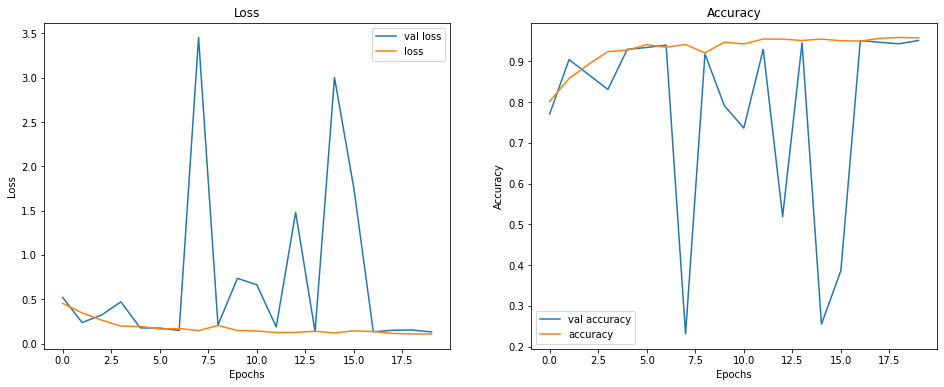

Test Accuracy = 0.82
Recall = 0.55


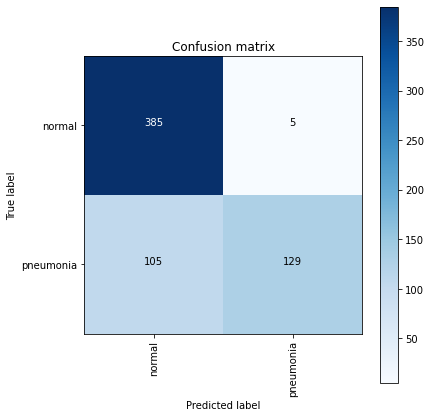

In [33]:
# process results

results_df = make_results(results_df,image_size,train_time,model_name,history_base, model, test_img, test_y)
display(results_df)
plot_results(history_base, model, test_img,  test_y,)

In [ ]:
# This model has good accuracy for test data, but recall is much higher than our base requirement 0.95.
# Another issue with the model is that accuracy on validation data had serious fluctuations.

##### 2) Baseline model with regulization

We will use L2 regulization in each layer, to reduce overfitting.
Will try different L2 coefficients to determine the best one

In [34]:
# Lets find the best L2 value.

In [35]:
L2_list = [0.001, 0.01, 0.1, 1]

In [36]:
L2_fin = []
for L2 in L2_list:
    model2 = models.Sequential()
    model2.add(layers.Dense(50, activation='relu', input_shape=(train_img.shape[1],), kernel_regularizer = l2(l2 = L2))) 
    model2.add(layers.Dense(25, activation='relu', kernel_regularizer = l2(l2 = L2)))
    model2.add(layers.Dense(10, activation='relu', kernel_regularizer = l2(l2 = L2)))
    model2.add(layers.Dense(1, activation='sigmoid'))
    model2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    history_model2 = model2.fit(train_img,
                    train_y,
                    epochs=20,
                    batch_size=32,
                    validation_data=(val_img, val_y),
                    verbose = 0)
    results_test = model2.evaluate(test_img, test_y)
    L2_fin.append((L2, results_test[1]))
        


20/20 [==============================] - 0s 3ms/step - loss: 0.7134 - accuracy: 0.6250


In [37]:
L2_best = sorted(L2_fin, key = lambda x: x[1], reverse = True)[0][0]
print("Best L2 regulization parameter:", L2_best)

Best L2 regulization parameter: 0.1


In [38]:
# Model with regulization

In [39]:
model_name = "Baseline with reg"
model2 = models.Sequential()
model2.add(layers.Dense(50, activation='relu', input_shape=(train_img.shape[1],), kernel_regularizer = l2(l2 = L2_best)))
model2.add(layers.Dense(25, activation='relu', kernel_regularizer = l2(l2 = L2_best)))
model2.add(layers.Dense(10, activation='relu', kernel_regularizer = l2(l2 = L2_best)))
model2.add(layers.Dense(1, activation='sigmoid'))
model2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

start = time.time()
history_model2 = model2.fit(train_img,
                    train_y,
                    epochs=20,
                    batch_size=32,
                    validation_data=(val_img, val_y),
                    verbose = 1)
end = time.time()
train_time = round(end-start, 0)


Epoch 1/20
156/156 [==============================] - 2s 10ms/step - loss: 11.5581 - accuracy: 0.7911 - val_loss: 8.9144 - val_accuracy: 0.7691
Epoch 2/20
156/156 [==============================] - 1s 9ms/step - loss: 6.3571 - accuracy: 0.8523 - val_loss: 4.6303 - val_accuracy: 0.8766
Epoch 3/20
156/156 [==============================] - 1s 8ms/step - loss: 3.5824 - accuracy: 0.8823 - val_loss: 2.6572 - val_accuracy: 0.8960
Epoch 4/20
156/156 [==============================] - 1s 8ms/step - loss: 2.1084 - accuracy: 0.8980 - val_loss: 1.6989 - val_accuracy: 0.8789
Epoch 5/20
156/156 [==============================] - 1s 8ms/step - loss: 1.3185 - accuracy: 0.9047 - val_loss: 1.1662 - val_accuracy: 0.8606
Epoch 6/20
156/156 [==============================] - 1s 8ms/step - loss: 0.9031 - accuracy: 0.9021 - val_loss: 0.7412 - val_accuracy: 0.9040
Epoch 7/20
156/156 [==============================] - 1s 8ms/step - loss: 0.6760 - accuracy: 0.9051 - val_loss: 0.6105 - val_accuracy: 0.8811
Epoc

,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",615996,16.0,0.9573,0.9509,0.8237,0.5513
0,Baseline with reg,"(64, 64)",615996,26.0,0.9055,0.912,0.7404,0.3162


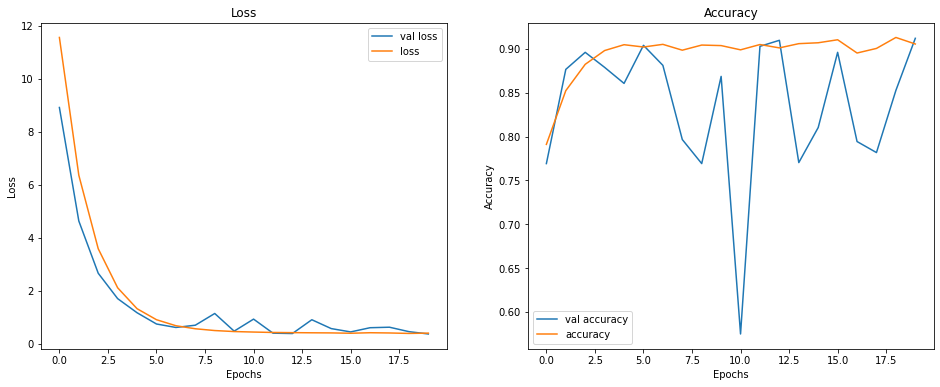

Test Accuracy = 0.74
Recall = 0.32


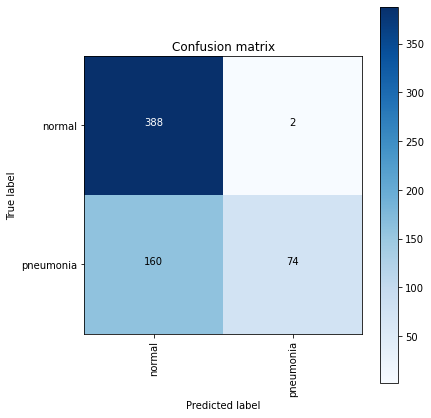

In [40]:
results_df = make_results(results_df,image_size,train_time,model_name,history_model2, model2, test_img, test_y)
display(results_df)
plot_results(history_model2, model2, test_img, test_y)

In [ ]:
# This model has worse accuracy for test data compare to baseline, recall is also much lower than our base requirement 0.95.
# Another issue with the model is that accuracy on validation data had serious fluctuations.

##### 3) Baseline model with regulization and Dropout

In [41]:
model_name = "Baseline with reg, dropout"
model3 = models.Sequential()
model3.add(layers.Dense(50, activation='relu', input_shape=(train_img.shape[1],), kernel_regularizer = l2(l2 = L2_best)))
model3.add(layers.Dense(25, activation='relu', kernel_regularizer = l2(l2 = L2_best)))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(10, activation='relu', kernel_regularizer = l2(l2 = L2_best)))
model3.add(layers.Dense(1, activation='sigmoid'))


In [42]:
model3.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])
start = time.time()
history_model3 = model3.fit(train_img,
                    train_y,
                    epochs=20,
                    batch_size=32,
                    validation_data=(val_img, val_y))
end = time.time()
train_time = round(end-start, 0)

Epoch 1/20
156/156 [==============================] - 2s 9ms/step - loss: 11.4883 - accuracy: 0.7429 - val_loss: 8.3788 - val_accuracy: 0.7691
Epoch 2/20
156/156 [==============================] - 1s 9ms/step - loss: 6.3409 - accuracy: 0.8160 - val_loss: 4.6815 - val_accuracy: 0.7806
Epoch 3/20
156/156 [==============================] - 1s 8ms/step - loss: 3.6050 - accuracy: 0.8402 - val_loss: 2.6773 - val_accuracy: 0.9131
Epoch 4/20
156/156 [==============================] - 1s 8ms/step - loss: 2.1478 - accuracy: 0.8618 - val_loss: 1.8425 - val_accuracy: 0.7280
Epoch 5/20
156/156 [==============================] - 1s 8ms/step - loss: 1.3584 - accuracy: 0.8702 - val_loss: 1.0513 - val_accuracy: 0.8903
Epoch 6/20
156/156 [==============================] - 1s 9ms/step - loss: 0.9380 - accuracy: 0.8763 - val_loss: 0.7400 - val_accuracy: 0.9234
Epoch 7/20
156/156 [==============================] - 1s 8ms/step - loss: 0.7143 - accuracy: 0.8769 - val_loss: 0.6081 - val_accuracy: 0.8720
Epoch

,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",615996,16.0,0.9573,0.9509,0.8237,0.5513
0,Baseline with reg,"(64, 64)",615996,26.0,0.9055,0.912,0.7404,0.3162
0,"Baseline with reg, dropout","(64, 64)",615996,25.0,0.8849,0.9166,0.7612,0.3718


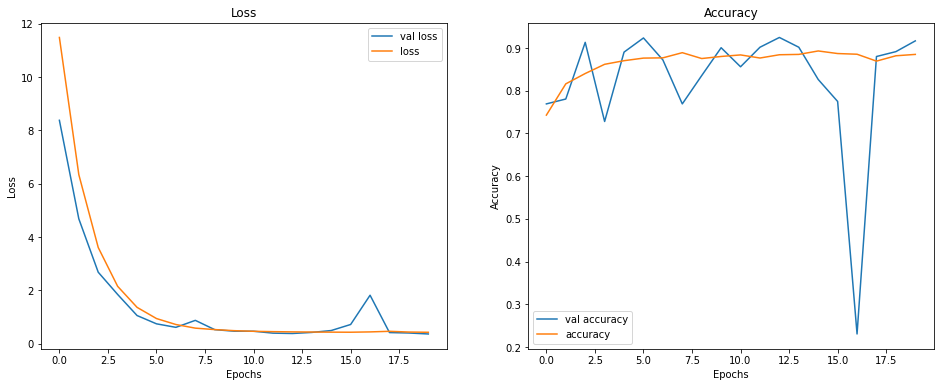

Test Accuracy = 0.76
Recall = 0.37


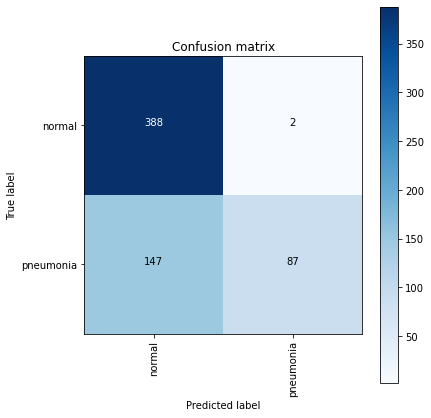

In [43]:
results_df = make_results(results_df,image_size,train_time,model_name,history_model3, model3, test_img, test_y)
display(results_df)
plot_results(history_model3, model3, test_img, test_y)

In [ ]:
# This model has worse accuracy for test data compare to baseline, recall is also much lower than our base requirement 0.95.
# Another issue with the model is that accuracy on validation data had serious fluctuations. However fluctations become lower.

##### 4) Baseline model with regulization and Dropout. Changed  optimizer to Adam

In [44]:
model_name = "Baseline with reg, dropout, optimizer"

model4 = models.Sequential()
model4.add(layers.Dense(50, activation='relu', input_shape=(train_img.shape[1],), kernel_regularizer = l2(l2 = L2_best)))
model4.add(layers.Dense(25, activation='relu', kernel_regularizer = l2(l2 = L2_best)))
model4.add(layers.Dropout(0.5))
model4.add(layers.Dense(10, activation='relu', kernel_regularizer = l2(l2 = L2_best)))
model4.add(layers.Dense(1, activation='sigmoid'))

In [45]:
model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
start = time.time()
history_model4 = model4.fit(train_img,
                    train_y,
                    epochs=20,
                    batch_size=32,
                    validation_data=(val_img, val_y))
end = time.time()
train_time = round(end-start, 0)

Epoch 1/20
156/156 [==============================] - 2s 11ms/step - loss: 4.1132 - accuracy: 0.7290 - val_loss: 1.8953 - val_accuracy: 0.7691
Epoch 2/20
156/156 [==============================] - 1s 9ms/step - loss: 1.3279 - accuracy: 0.7681 - val_loss: 0.9481 - val_accuracy: 0.7691
Epoch 3/20
156/156 [==============================] - 1s 8ms/step - loss: 0.8012 - accuracy: 0.7689 - val_loss: 0.6849 - val_accuracy: 0.7691
Epoch 4/20
156/156 [==============================] - 1s 8ms/step - loss: 0.6430 - accuracy: 0.7689 - val_loss: 0.5931 - val_accuracy: 0.7691
Epoch 5/20
156/156 [==============================] - 1s 8ms/step - loss: 0.5793 - accuracy: 0.7689 - val_loss: 0.5602 - val_accuracy: 0.7691
Epoch 6/20
156/156 [==============================] - 1s 8ms/step - loss: 0.5554 - accuracy: 0.7689 - val_loss: 0.5461 - val_accuracy: 0.7691
Epoch 7/20
156/156 [==============================] - 1s 8ms/step - loss: 0.5401 - accuracy: 0.7689 - val_loss: 0.5831 - val_accuracy: 0.7691
Epoch

In [46]:
results_train4 = model4.evaluate(train_img, train_y)

156/156 [==============================] - 1s 3ms/step - loss: 0.4328 - accuracy: 0.8281


,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",615996,16.0,0.9573,0.9509,0.8237,0.5513
0,Baseline with reg,"(64, 64)",615996,26.0,0.9055,0.912,0.7404,0.3162
0,"Baseline with reg, dropout","(64, 64)",615996,25.0,0.8849,0.9166,0.7612,0.3718
0,"Baseline with reg, dropout, optimizer","(64, 64)",615996,27.0,0.8316,0.8274,0.6571,0.0855


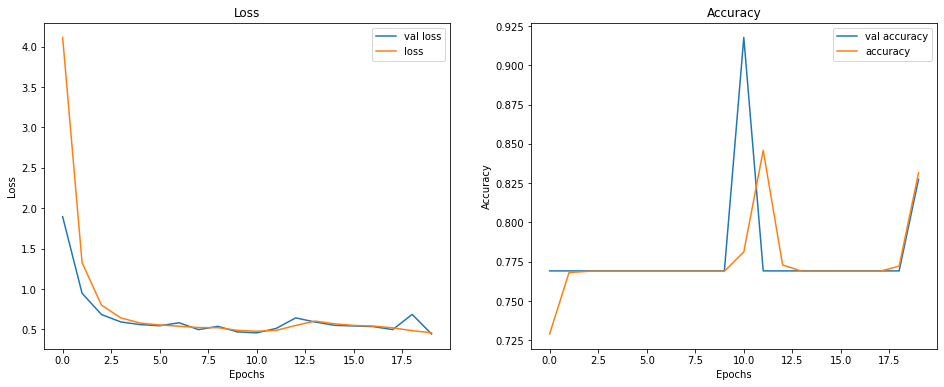

Test Accuracy = 0.66
Recall = 0.09


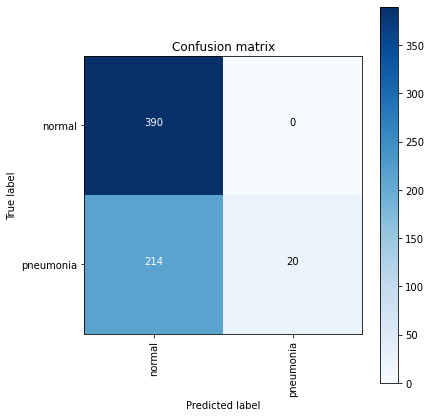

In [47]:
results_df = make_results(results_df,image_size,train_time,model_name,history_model4, model4, test_img, test_y)
display(results_df)
plot_results(history_model4, model4, test_img, test_y)

In [48]:
results_test4 = model4.evaluate(test_img, test_y)
print(f"Test set results accuracy {results_test4[1]}")

20/20 [==============================] - 0s 4ms/step - loss: 0.7991 - accuracy: 0.6571
Test set results accuracy 0.6570512652397156


In [ ]:
# Model has serious overfitting issues. 

##### 5) Baseline + regulization + Dropout + Adam optimizer + increased train time

In [49]:
model_name = "Baseline with reg, dropout, optimizer + extra train time"

model5 = models.Sequential()
model5.add(layers.Dense(50, activation='relu', input_shape=(train_img.shape[1],), kernel_regularizer = l2(l2 = 0.01)))
model5.add(layers.Dense(25, activation='relu', kernel_regularizer = l2(l2 = 0.01)))
model5.add(layers.Dropout(0.5))
model5.add(layers.Dense(10, activation='relu', kernel_regularizer = l2(l2 = 0.01)))
model5.add(layers.Dense(1, activation='sigmoid'))

In [50]:
model5.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
start = time.time()
history_model5 = model5.fit(train_img,
                    train_y,
                    epochs=50,
                    batch_size=50,
                    validation_data=(val_img, val_y))
end = time.time()
train_time = round(end-start, 0)

Epoch 1/50
100/100 [==============================] - 2s 12ms/step - loss: 1.4834 - accuracy: 0.7671 - val_loss: 0.9223 - val_accuracy: 0.9029
Epoch 2/50
100/100 [==============================] - 1s 10ms/step - loss: 0.8064 - accuracy: 0.8394 - val_loss: 0.5938 - val_accuracy: 0.8800
Epoch 3/50
100/100 [==============================] - 1s 10ms/step - loss: 0.5972 - accuracy: 0.8584 - val_loss: 0.4362 - val_accuracy: 0.9269
Epoch 4/50
100/100 [==============================] - 1s 11ms/step - loss: 0.4789 - accuracy: 0.8854 - val_loss: 0.4054 - val_accuracy: 0.9269
Epoch 5/50
100/100 [==============================] - 1s 10ms/step - loss: 0.4082 - accuracy: 0.9156 - val_loss: 0.3343 - val_accuracy: 0.9349
Epoch 6/50
100/100 [==============================] - 1s 9ms/step - loss: 0.3765 - accuracy: 0.9172 - val_loss: 0.3344 - val_accuracy: 0.9360
Epoch 7/50
100/100 [==============================] - 1s 10ms/step - loss: 0.3487 - accuracy: 0.9252 - val_loss: 0.2927 - val_accuracy: 0.9417


,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",615996,16.0,0.9573,0.9509,0.8237,0.5513
0,Baseline with reg,"(64, 64)",615996,26.0,0.9055,0.912,0.7404,0.3162
0,"Baseline with reg, dropout","(64, 64)",615996,25.0,0.8849,0.9166,0.7612,0.3718
0,"Baseline with reg, dropout, optimizer","(64, 64)",615996,27.0,0.8316,0.8274,0.6571,0.0855
0,"Baseline with reg, dropout, optimizer + extra ...","(64, 64)",615996,61.0,0.9464,0.9451,0.859,0.6624


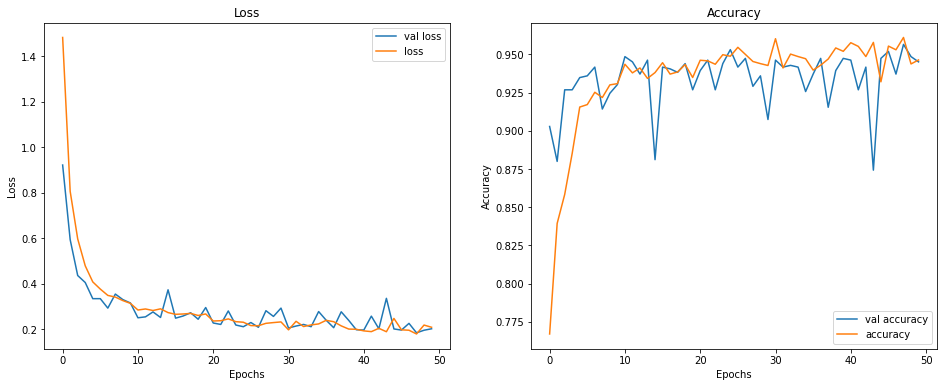

Test Accuracy = 0.86
Recall = 0.66


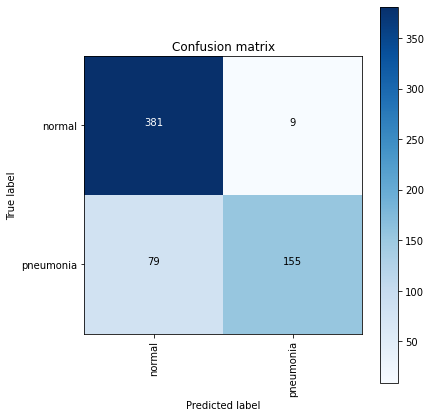

In [51]:
results_df = make_results(results_df,image_size,train_time,model_name,history_model5, model5, test_img, test_y)
display(results_df)
plot_results(history_model5, model5, test_img, test_y)

In [52]:
results_test5 = model5.evaluate(test_img, test_y)
print(f"Test set results accuracy {results_test5[1]}")

20/20 [==============================] - 0s 5ms/step - loss: 0.4638 - accuracy: 0.8590
Test set results accuracy 0.8589743375778198


In [ ]:
# This model is preferable compare to other baseline models, however recall is also much lower than our base requirement 0.95.
# Accuracy fluctations almost dissapear.

##### 6) Basic CNN model, image shape 64x64

In [53]:
model_name = "Basic CNN"

model_CNN = models.Sequential()
model_CNN.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64, 3)))
model_CNN.add(layers.MaxPooling2D((2, 2)))

model_CNN.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_CNN.add(layers.MaxPooling2D((2, 2)))

model_CNN.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN.add(layers.MaxPooling2D((2, 2)))

model_CNN.add(layers.Flatten())
model_CNN.add(layers.Dense(30, activation='relu'))
model_CNN.add(layers.Dense(10, activation='relu'))
model_CNN.add(layers.Dense(1, activation='sigmoid'))

model_CNN.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

In [54]:
start = time.time()
history_CNN1 = model_CNN.fit(train_images,
                    train_y,
                    epochs=20,
                    batch_size=32,
                    validation_data=(val_images, val_y))
end = time.time()
train_time = round(end-start, 0)

Epoch 1/25
156/156 [==============================] - 27s 166ms/step - loss: 0.5430 - accuracy: 0.7689 - val_loss: 0.5374 - val_accuracy: 0.7691
Epoch 2/25
156/156 [==============================] - 25s 157ms/step - loss: 0.4920 - accuracy: 0.7729 - val_loss: 1.0619 - val_accuracy: 0.2309
Epoch 3/25
156/156 [==============================] - 24s 154ms/step - loss: 0.5067 - accuracy: 0.7639 - val_loss: 0.4146 - val_accuracy: 0.8034
Epoch 4/25
156/156 [==============================] - 23s 148ms/step - loss: 0.4031 - accuracy: 0.8261 - val_loss: 0.8300 - val_accuracy: 0.4777
Epoch 5/25
156/156 [==============================] - 23s 148ms/step - loss: 0.3177 - accuracy: 0.8660 - val_loss: 0.2564 - val_accuracy: 0.8994
Epoch 6/25
156/156 [==============================] - 23s 147ms/step - loss: 0.2308 - accuracy: 0.9073 - val_loss: 0.2715 - val_accuracy: 0.8846
Epoch 7/25
156/156 [==============================] - 23s 145ms/step - loss: 0.1909 - accuracy: 0.9259 - val_loss: 0.9371 - val_ac

In [55]:
results_test = model_CNN.evaluate(test_images, test_y)

20/20 [==============================] - 1s 27ms/step - loss: 0.6244 - accuracy: 0.8221


,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",615996,16.0,0.9573,0.9509,0.8237,0.5513
0,Baseline with reg,"(64, 64)",615996,26.0,0.9055,0.912,0.7404,0.3162
0,"Baseline with reg, dropout","(64, 64)",615996,25.0,0.8849,0.9166,0.7612,0.3718
0,"Baseline with reg, dropout, optimizer","(64, 64)",615996,27.0,0.8316,0.8274,0.6571,0.0855
0,"Baseline with reg, dropout, optimizer + extra ...","(64, 64)",615996,61.0,0.9464,0.9451,0.859,0.6624
0,Basic CNN,"(64, 64)",105279,552.0,0.9724,0.9509,0.8221,0.5513


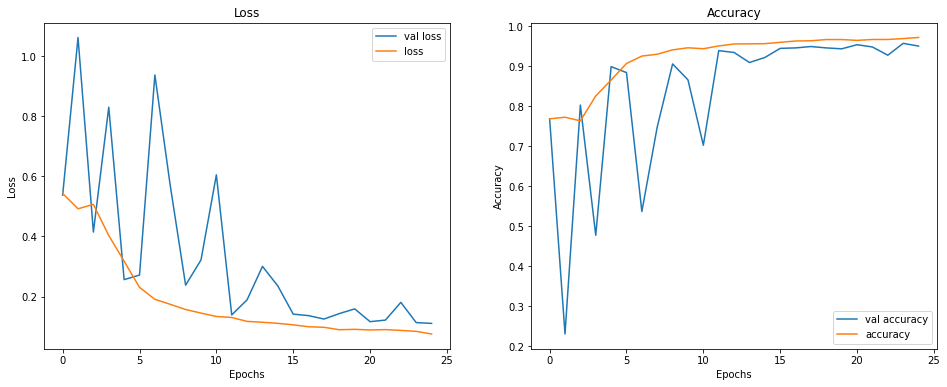

Test Accuracy = 0.82
Recall = 0.55


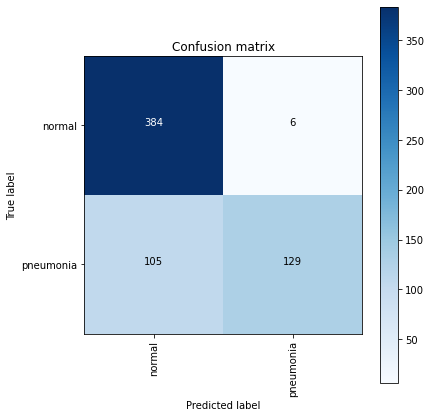

In [57]:
results_df = make_results(results_df,image_size,train_time,model_name,history_CNN1, model_CNN, test_images, test_y)
display(results_df)
plot_results(history_CNN1, model_CNN, test_images, test_y)

##### 7) Basic CNN, shape 64 x 64 with regulization

In [58]:
model_name = "Basic CNN with reg, dropout"

model_CNN2 = models.Sequential()
model_CNN2.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64, 3)))
model_CNN2.add(layers.MaxPooling2D((2, 2)))

model_CNN2.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_CNN2.add(layers.MaxPooling2D((2, 2)))

model_CNN2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN2.add(layers.MaxPooling2D((2, 2)))

model_CNN2.add(layers.Flatten())
model_CNN2.add(layers.Dense(40, activation='relu', kernel_regularizer = l2(l2 = L2_best)))
model_CNN2.add(layers.Dense(1, activation='sigmoid'))

model_CNN2.compile(loss='binary_crossentropy',
              optimizer="Adam",
              metrics=['accuracy'])

In [59]:
start = time.time()
history_CNN2 = model_CNN2.fit(train_images,
                    train_y,
                    epochs=20,
                    batch_size=32,
                    validation_data=(val_images, val_y))
end = time.time()
train_time = round(end-start, 0)

Epoch 1/25
156/156 [==============================] - 20s 119ms/step - loss: 1.2115 - accuracy: 0.8382 - val_loss: 0.3381 - val_accuracy: 0.9006
Epoch 2/25
156/156 [==============================] - 26s 168ms/step - loss: 0.2287 - accuracy: 0.9363 - val_loss: 0.9733 - val_accuracy: 0.5840
Epoch 3/25
156/156 [==============================] - 26s 167ms/step - loss: 0.2615 - accuracy: 0.9214 - val_loss: 0.1865 - val_accuracy: 0.9406
Epoch 4/25
156/156 [==============================] - 26s 164ms/step - loss: 0.1780 - accuracy: 0.9500 - val_loss: 0.1799 - val_accuracy: 0.9451
Epoch 5/25
156/156 [==============================] - 26s 170ms/step - loss: 0.1645 - accuracy: 0.9549 - val_loss: 0.1958 - val_accuracy: 0.9406
Epoch 6/25
156/156 [==============================] - 26s 167ms/step - loss: 0.1486 - accuracy: 0.9549 - val_loss: 0.2007 - val_accuracy: 0.9406
Epoch 7/25
156/156 [==============================] - 25s 157ms/step - loss: 0.1371 - accuracy: 0.9615 - val_loss: 0.1649 - val_ac

In [60]:
results_test = model_CNN2.evaluate(test_images, test_y)

20/20 [==============================] - 1s 26ms/step - loss: 0.3300 - accuracy: 0.8878


,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",615996,16.0,0.9573,0.9509,0.8237,0.5513
0,Baseline with reg,"(64, 64)",615996,26.0,0.9055,0.912,0.7404,0.3162
0,"Baseline with reg, dropout","(64, 64)",615996,25.0,0.8849,0.9166,0.7612,0.3718
0,"Baseline with reg, dropout, optimizer","(64, 64)",615996,27.0,0.8316,0.8274,0.6571,0.0855
0,"Baseline with reg, dropout, optimizer + extra ...","(64, 64)",615996,61.0,0.9464,0.9451,0.859,0.6624
0,Basic CNN,"(64, 64)",105279,552.0,0.9724,0.9509,0.8221,0.5513
0,Basic CNN with reg,"(64, 64)",128049,588.0,0.9796,0.9691,0.8878,0.7137
0,Basic CNN with reg,"(64, 64)",128049,588.0,0.9796,0.9691,0.8878,0.7137


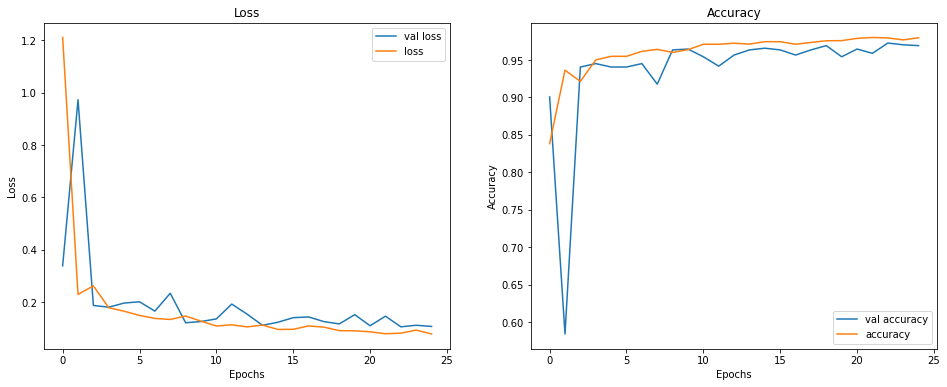

Test Accuracy = 0.89
Recall = 0.71


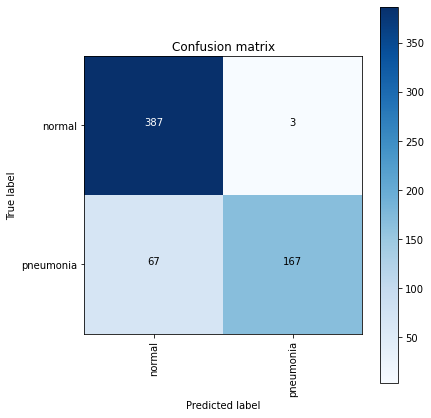

In [62]:
results_df = make_results(results_df,image_size,train_time,model_name,history_CNN2, model_CNN2, test_images, test_y)
display(results_df)
plot_results(history_CNN2, model_CNN2, test_images, test_y)

##### 7) Basic CNN, shape 100 x 100

In [63]:
# # get all the data in the directory split/train, and reshape them
# train_generator_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
#         train_folder, 
#         target_size=(100, 100), batch_size= train_img_number)

# # get all the data in the directory split/validation, and reshape them
# val_generator_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
#         val_folder, 
#         target_size=(100, 100), batch_size = val_img_number)

# # get all the data in the directory split/test, and reshape them
# test_generator_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
#         test_folder, 
#         target_size=(100, 100), batch_size = test_img_number) 

# Reshape images to 100x100

image_size = (100,100)
train_generator_100, val_generator_100, test_generator_100 = process_data_no_aug(image_size)

train_images2, train_labels2 = next(train_generator_100)
test_images2, test_labels2 = next(test_generator_100)
val_images2, val_labels2 = next(val_generator_100)




Found 4963 images belonging to 2 classes.
Found 875 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [64]:
# Reshape images
train_img2 = train_images2.reshape(train_images2.shape[0], -1)
test_img2 = test_images2.reshape(test_images2.shape[0], -1)
val_img2 = val_images2.reshape(val_images2.shape[0], -1)

# Check the shape after. 
print(train_img2.shape)
print(test_img2.shape)
print(val_img2.shape)

(4963, 30000)
(624, 30000)
(875, 30000)


In [65]:
# Labels
train_y2 = np.reshape(train_labels[:,0], (train_img_number,1))
test_y2 = np.reshape(test_labels[:,0], (test_img_number,1))
val_y2 = np.reshape(val_labels[:,0], (val_img_number,1))

In [66]:
# Create model.
model_name = "Basic CNN 100x100"

model_CNN3 = models.Sequential()
model_CNN3.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(100 ,100, 3)))
model_CNN3.add(layers.MaxPooling2D((2, 2)))

model_CNN3.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_CNN3.add(layers.MaxPooling2D((2, 2)))

model_CNN3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN3.add(layers.MaxPooling2D((2, 2)))

model_CNN3.add(layers.Flatten())
model_CNN3.add(layers.Dense(30, activation='relu'))
model_CNN3.add(layers.Dense(10, activation='relu'))
model_CNN3.add(layers.Dense(1, activation='sigmoid'))

model_CNN3.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

In [67]:
start = time.time()

history_CNN3 = model_CNN3.fit(train_images2,
                    train_y2,
                    epochs=20,
                    batch_size=50,
                    validation_data=(val_images2, val_y2))
end = time.time()
train_time = round(end-start, 0)


Epoch 1/25
100/100 [==============================] - 38s 376ms/step - loss: 0.5465 - accuracy: 0.7630 - val_loss: 0.5265 - val_accuracy: 0.7691
Epoch 2/25
100/100 [==============================] - 43s 425ms/step - loss: 0.4937 - accuracy: 0.7703 - val_loss: 0.4408 - val_accuracy: 0.7691
Epoch 3/25
100/100 [==============================] - 43s 425ms/step - loss: 0.4310 - accuracy: 0.8017 - val_loss: 0.4604 - val_accuracy: 0.8423
Epoch 4/25
100/100 [==============================] - 49s 487ms/step - loss: 0.3713 - accuracy: 0.8366 - val_loss: 0.2875 - val_accuracy: 0.8731
Epoch 5/25
100/100 [==============================] - 44s 434ms/step - loss: 0.2901 - accuracy: 0.8813 - val_loss: 0.2187 - val_accuracy: 0.9131
Epoch 6/25
100/100 [==============================] - 41s 411ms/step - loss: 0.2262 - accuracy: 0.9087 - val_loss: 0.3174 - val_accuracy: 0.8709
Epoch 7/25
100/100 [==============================] - 40s 403ms/step - loss: 0.1751 - accuracy: 0.9349 - val_loss: 0.3454 - val_ac

In [68]:
results_test = model_CNN3.evaluate(test_images2, test_y2)

20/20 [==============================] - 1s 63ms/step - loss: 0.7637 - accuracy: 0.7965


,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",615996,16.0,0.9573,0.9509,0.8237,0.5513
0,Baseline with reg,"(64, 64)",615996,26.0,0.9055,0.912,0.7404,0.3162
0,"Baseline with reg, dropout","(64, 64)",615996,25.0,0.8849,0.9166,0.7612,0.3718
0,"Baseline with reg, dropout, optimizer","(64, 64)",615996,27.0,0.8316,0.8274,0.6571,0.0855
0,"Baseline with reg, dropout, optimizer + extra ...","(64, 64)",615996,61.0,0.9464,0.9451,0.859,0.6624
0,Basic CNN,"(64, 64)",105279,552.0,0.9724,0.9509,0.8221,0.5513
0,Basic CNN with reg,"(64, 64)",128049,588.0,0.9796,0.9691,0.8878,0.7137
0,Basic CNN with reg,"(64, 64)",128049,588.0,0.9796,0.9691,0.8878,0.7137
0,Basic CNN 100x100,"(100, 100)",228159,1084.0,0.9726,0.9577,0.7965,0.4744


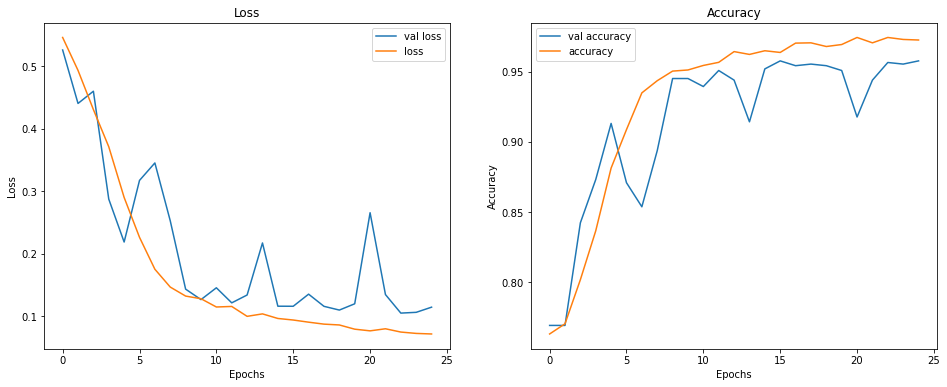

Test Accuracy = 0.80
Recall = 0.47


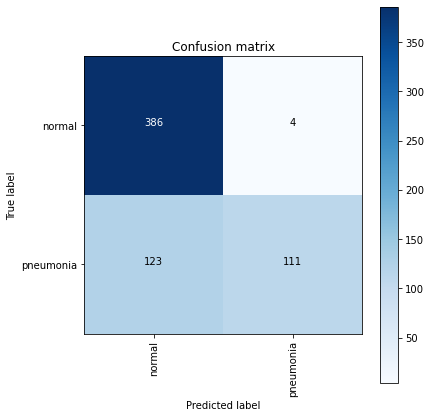

In [69]:
results_df = make_results(results_df,image_size,train_time,model_name,history_CNN3, model_CNN3, test_images2, test_y2)
display(results_df)
plot_results(history_CNN3, model_CNN3, test_images2, test_y2)

##### 8) Basic CNN, shape 100 x 100 with regulization and dropout

In [70]:
model_name = "Basic CNN 100x100 with reg and dropout"

model_CNN4 = models.Sequential()
model_CNN4.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(100 ,100, 3)))
model_CNN4.add(layers.MaxPooling2D((2, 2)))

model_CNN4.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_CNN4.add(layers.MaxPooling2D((2, 2)))

model_CNN4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN4.add(layers.MaxPooling2D((2, 2)))

model_CNN4.add(layers.Flatten())
model_CNN4.add(layers.Dense(30, activation='relu', kernel_regularizer = l2(l2 = 0.01)))
model_CNN4.add(layers.Dropout(0.3))
model_CNN4.add(layers.Dense(1, activation='sigmoid'))

model_CNN4.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

In [71]:
start = time.time()

history_CNN4 = model_CNN4.fit(train_images2,
                    train_y2,
                    epochs=20,
                    batch_size=32,
                    validation_data=(val_images2, val_y2))
end = time.time()
train_time = round(end-start, 0)

Epoch 1/20
156/156 [==============================] - 57s 360ms/step - loss: 1.1349 - accuracy: 0.7643 - val_loss: 1.0690 - val_accuracy: 0.7691
Epoch 2/20
156/156 [==============================] - 50s 318ms/step - loss: 1.0248 - accuracy: 0.7780 - val_loss: 1.0533 - val_accuracy: 0.7691
Epoch 3/20
156/156 [==============================] - 50s 318ms/step - loss: 0.9319 - accuracy: 0.8037 - val_loss: 1.1837 - val_accuracy: 0.7691
Epoch 4/20
156/156 [==============================] - 60s 387ms/step - loss: 0.8458 - accuracy: 0.8336 - val_loss: 0.9072 - val_accuracy: 0.7691
Epoch 5/20
156/156 [==============================] - 71s 458ms/step - loss: 0.7655 - accuracy: 0.8729 - val_loss: 0.6892 - val_accuracy: 0.9029
Epoch 6/20
156/156 [==============================] - 52s 335ms/step - loss: 0.6812 - accuracy: 0.9059 - val_loss: 1.2778 - val_accuracy: 0.4926
Epoch 7/20
156/156 [==============================] - 48s 307ms/step - loss: 0.6408 - accuracy: 0.9111 - val_loss: 1.6300 - val_ac

In [72]:
results_test = model_CNN4.evaluate(test_images2, test_y2)

20/20 [==============================] - 2s 68ms/step - loss: 0.5835 - accuracy: 0.8702


,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",615996,16.0,0.9573,0.9509,0.8237,0.5513
0,Baseline with reg,"(64, 64)",615996,26.0,0.9055,0.912,0.7404,0.3162
0,"Baseline with reg, dropout","(64, 64)",615996,25.0,0.8849,0.9166,0.7612,0.3718
0,"Baseline with reg, dropout, optimizer","(64, 64)",615996,27.0,0.8316,0.8274,0.6571,0.0855
0,"Baseline with reg, dropout, optimizer + extra ...","(64, 64)",615996,61.0,0.9464,0.9451,0.859,0.6624
0,Basic CNN,"(64, 64)",105279,552.0,0.9724,0.9509,0.8221,0.5513
0,Basic CNN with reg,"(64, 64)",128049,588.0,0.9796,0.9691,0.8878,0.7137
0,Basic CNN with reg,"(64, 64)",128049,588.0,0.9796,0.9691,0.8878,0.7137
0,Basic CNN 100x100,"(100, 100)",228159,1084.0,0.9726,0.9577,0.7965,0.4744
0,Basic CNN 100x100 with reg,"(100, 100)",227869,959.0,0.9651,0.9451,0.8702,0.6966


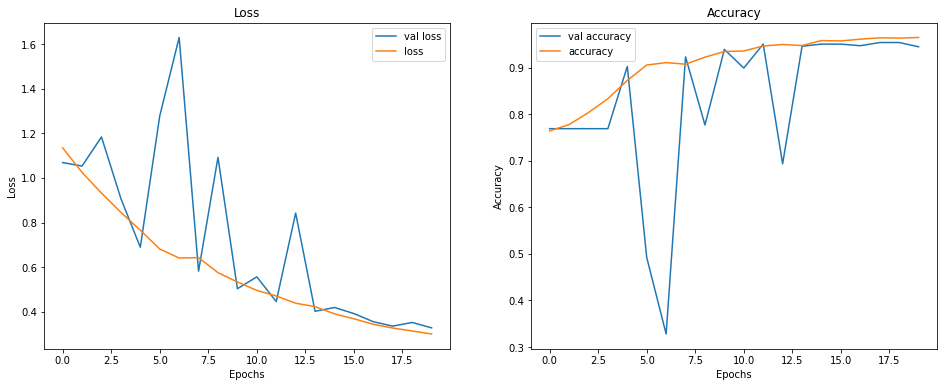

Test Accuracy = 0.87
Recall = 0.70


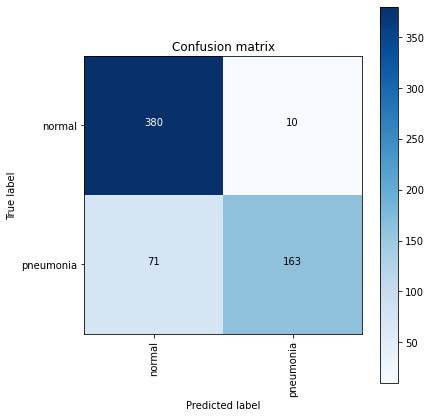

In [73]:
results_df = make_results(results_df,image_size,train_time,model_name,history_CNN4, model_CNN4, test_images2, test_y2)
display(results_df)
plot_results(history_CNN4, model_CNN4, test_images2, test_y2)

##### Change data

In [74]:
image_size = (100,100)
train_generator_arg_100, val_generator_arg_100, test_generator_arg_100 = process_data_aug(image_size, batch_size)


Found 624 images belonging to 2 classes.
Found 875 images belonging to 2 classes.
Found 4963 images belonging to 2 classes.


In [75]:
# train_datagen_arg_100 = ImageDataGenerator(rescale=1./255, 
#                                    rotation_range=40, 
#                                    width_shift_range=0.1, 
#                                    height_shift_range=0.1, 
#                                    shear_range=0.2, 
#                                    horizontal_flip=False)
# test_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
#         test_folder, 
#         target_size=(100, 100), 
#         batch_size = test_img_number,
#         class_mode='binary') 

# # get all the data in the directory split/validation, and reshape them
# val_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
#         val_folder, 
#         target_size=(100, 100),
#         batch_size = 32,
#         class_mode='binary')

# # get all the data in the directory split/train , and reshape them
# train_generator_arg_100 = train_datagen_arg_100.flow_from_directory(
#         train_folder, target_size=(100, 100),
#         batch_size = 64, class_mode='binary')


In [76]:
train_images_100_arg, train_labels_100_arg = next(train_generator_arg_100)
test_images_100_arg, test_labels_100_arg = next(test_generator_arg_100)
val_images_100_arg, val_labels_100_arg = next(val_generator_arg_100)

##### 9) Augment CNN, shape 100 x 100 with regularization

In [77]:
model_name = "Augmented CNN 100x100 with reg"

model_CNN6 = models.Sequential()
model_CNN6.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(100 ,100, 3)))
model_CNN6.add(layers.MaxPooling2D((2, 2)))

model_CNN6.add(layers.Conv2D(32, (4, 4), activation='relu', kernel_regularizer = l2(l2 = 0.01)))
model_CNN6.add(layers.MaxPooling2D((2, 2)))

model_CNN6.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN6.add(layers.MaxPooling2D((2, 2)))

model_CNN6.add(layers.Flatten())
model_CNN6.add(layers.Dense(50, activation='relu', kernel_regularizer = l2(l2 = 0.01)))
model_CNN6.add(layers.Dropout(0.3))
model_CNN6.add(layers.Dense(1, activation='sigmoid'))

model_CNN6.compile(loss='binary_crossentropy',
              optimizer="Adam",
              metrics=['accuracy'])

In [78]:
start = time.time()
history_CNN6 = model_CNN6.fit_generator(train_generator_arg_100, 
                                steps_per_epoch=25, 
                                epochs=20, 
                                validation_data=val_generator_arg_100, 
                                validation_steps=25)
end = time.time()
train_time = round(end-start, 0)

Epoch 1/20
25/25 [==============================] - 71s 3s/step - loss: 1.2162 - accuracy: 0.7462 - val_loss: 0.7986 - val_accuracy: 0.7675
Epoch 2/20
25/25 [==============================] - 75s 3s/step - loss: 0.7102 - accuracy: 0.7689 - val_loss: 0.6295 - val_accuracy: 0.7663
Epoch 3/20
25/25 [==============================] - 70s 3s/step - loss: 0.5982 - accuracy: 0.7747 - val_loss: 0.5759 - val_accuracy: 0.7763
Epoch 4/20
25/25 [==============================] - 74s 3s/step - loss: 0.5318 - accuracy: 0.7837 - val_loss: 0.5321 - val_accuracy: 0.7812
Epoch 5/20
25/25 [==============================] - 74s 3s/step - loss: 0.4878 - accuracy: 0.7817 - val_loss: 0.4742 - val_accuracy: 0.8938
Epoch 6/20
25/25 [==============================] - 71s 3s/step - loss: 0.4234 - accuracy: 0.8288 - val_loss: 0.3864 - val_accuracy: 0.8662
Epoch 7/20
25/25 [==============================] - 74s 3s/step - loss: 0.4008 - accuracy: 0.8413 - val_loss: 0.3202 - val_accuracy: 0.9013
Epoch 8/20
25/25 [==

,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",615996,16.0,0.9573,0.9509,0.8237,0.5513
0,Baseline with reg,"(64, 64)",615996,26.0,0.9055,0.912,0.7404,0.3162
0,"Baseline with reg, dropout","(64, 64)",615996,25.0,0.8849,0.9166,0.7612,0.3718
0,"Baseline with reg, dropout, optimizer","(64, 64)",615996,27.0,0.8316,0.8274,0.6571,0.0855
0,"Baseline with reg, dropout, optimizer + extra ...","(64, 64)",615996,61.0,0.9464,0.9451,0.859,0.6624
0,Basic CNN,"(64, 64)",105279,552.0,0.9724,0.9509,0.8221,0.5513
0,Basic CNN with reg,"(64, 64)",128049,588.0,0.9796,0.9691,0.8878,0.7137
0,Basic CNN with reg,"(64, 64)",128049,588.0,0.9796,0.9691,0.8878,0.7137
0,Basic CNN 100x100,"(100, 100)",228159,1084.0,0.9726,0.9577,0.7965,0.4744
0,Basic CNN 100x100 with reg,"(100, 100)",227869,959.0,0.9651,0.9451,0.8702,0.6966


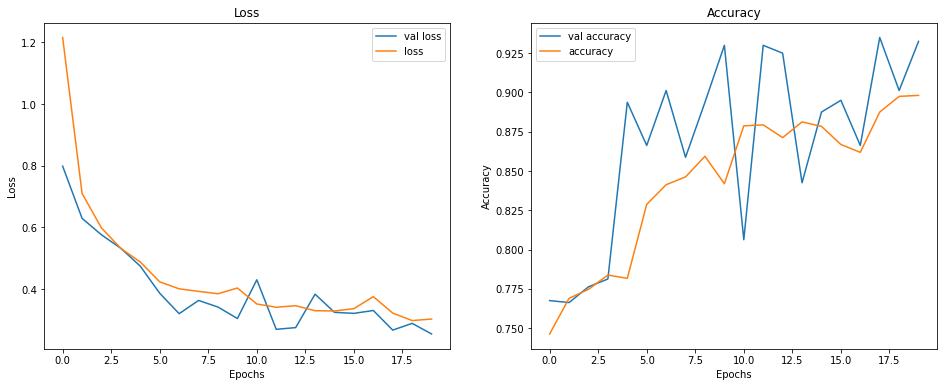

Test Accuracy = 0.43
Recall = 0.66


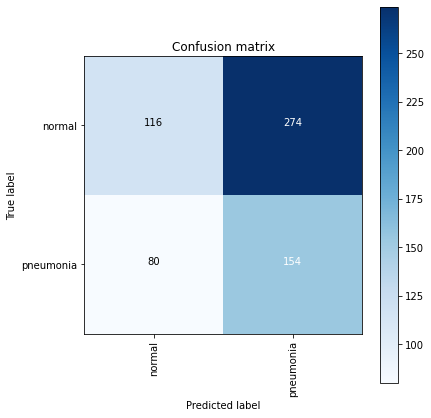

In [81]:
results_df = make_results(results_df,image_size,train_time,model_name,history_CNN6, model_CNN6, test_images_100_arg, test_y)
display(results_df)
plot_results(history_CNN6, model_CNN6, test_images_100_arg, test_y)

argumented CNN 100 batch 64/32 Rmsprop

##### 10) Augment CNN, shape 100 x 100 with reg and RMSprop optimizer

In [82]:
model_name = "Augmented CNN 100x100 with reg and RMSprop optimizer"

model_CNN8 = models.Sequential()
model_CNN8.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(100 ,100, 3)))
model_CNN8.add(layers.MaxPooling2D((2, 2)))

model_CNN8.add(layers.Conv2D(32, (4, 4), activation='relu', kernel_regularizer = l2(l2 = 0.01)))
model_CNN8.add(layers.MaxPooling2D((2, 2)))

model_CNN8.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN8.add(layers.MaxPooling2D((2, 2)))

model_CNN8.add(layers.Flatten())
model_CNN8.add(layers.Dense(50, activation='relu', kernel_regularizer = l2(l2 = 0.01)))
model_CNN8.add(layers.Dropout(0.3))
model_CNN8.add(layers.Dense(1, activation='sigmoid'))

model_CNN8.compile(loss='binary_crossentropy',
              optimizer="rmsprop",
              metrics=['accuracy'])


In [83]:
start = time.time()

history_CNN8 = model_CNN8.fit_generator(train_generator_arg_100, 
                                steps_per_epoch=25, 
                                epochs=15, 
                                validation_data=val_generator_arg_100, 
                                validation_steps=25)

end = time.time()
train_time = round(end-start, 0)

Epoch 1/15
25/25 [==============================] - 69s 3s/step - loss: 1.1532 - accuracy: 0.7632 - val_loss: 0.7948 - val_accuracy: 0.7613
Epoch 2/15
25/25 [==============================] - 72s 3s/step - loss: 0.7151 - accuracy: 0.7708 - val_loss: 0.6619 - val_accuracy: 0.7775
Epoch 3/15
25/25 [==============================] - 71s 3s/step - loss: 0.6108 - accuracy: 0.7798 - val_loss: 0.5958 - val_accuracy: 0.7663
Epoch 4/15
25/25 [==============================] - 75s 3s/step - loss: 0.6072 - accuracy: 0.7500 - val_loss: 0.5816 - val_accuracy: 0.7675
Epoch 5/15
25/25 [==============================] - 69s 3s/step - loss: 0.5564 - accuracy: 0.7738 - val_loss: 0.5484 - val_accuracy: 0.7663
Epoch 6/15
25/25 [==============================] - 70s 3s/step - loss: 0.5340 - accuracy: 0.7569 - val_loss: 0.5791 - val_accuracy: 0.7725
Epoch 7/15
25/25 [==============================] - 81s 3s/step - loss: 0.5435 - accuracy: 0.7625 - val_loss: 0.5333 - val_accuracy: 0.7663
Epoch 8/15
25/25 [==

,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",615996,16.0,0.9573,0.9509,0.8237,0.5513
0,Baseline with reg,"(64, 64)",615996,26.0,0.9055,0.912,0.7404,0.3162
0,"Baseline with reg, dropout","(64, 64)",615996,25.0,0.8849,0.9166,0.7612,0.3718
0,"Baseline with reg, dropout, optimizer","(64, 64)",615996,27.0,0.8316,0.8274,0.6571,0.0855
0,"Baseline with reg, dropout, optimizer + extra ...","(64, 64)",615996,61.0,0.9464,0.9451,0.859,0.6624
0,Basic CNN,"(64, 64)",105279,552.0,0.9724,0.9509,0.8221,0.5513
0,Basic CNN with reg,"(64, 64)",128049,588.0,0.9796,0.9691,0.8878,0.7137
0,Basic CNN with reg,"(64, 64)",128049,588.0,0.9796,0.9691,0.8878,0.7137
0,Basic CNN 100x100,"(100, 100)",228159,1084.0,0.9726,0.9577,0.7965,0.4744
0,Basic CNN 100x100 with reg,"(100, 100)",227869,959.0,0.9651,0.9451,0.8702,0.6966


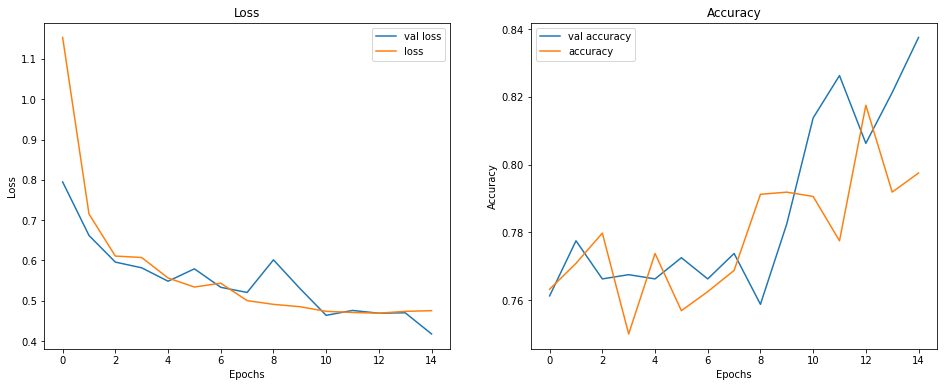

Test Accuracy = 0.39
Recall = 0.89


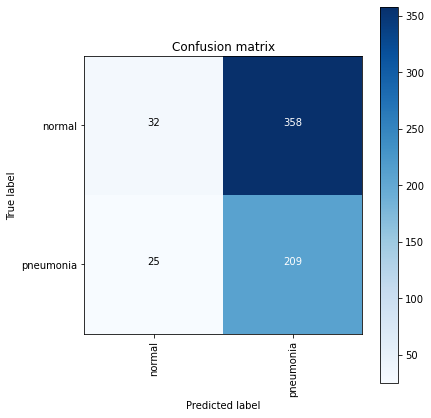

In [84]:
results_df = make_results(results_df,image_size,train_time,model_name,history_CNN8, model_CNN8, test_images_100_arg, test_y)
display(results_df)
plot_results(history_CNN8, model_CNN8, test_images_100_arg, test_y)

In [85]:
results_test = model_CNN8.evaluate(test_images_100_arg, test_y)

20/20 [==============================] - 1s 43ms/step - loss: 1.5202 - accuracy: 0.3862


##### 11) Augment CNN, shape 100 x 100 with reg with additional regularizer

In [86]:
model_name = "Augmented CNN 100x100 with additional reg, increased training time"
model_CNN9 = models.Sequential()
model_CNN9.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(100 ,100, 3)))
model_CNN9.add(layers.MaxPooling2D((2, 2)))

model_CNN9.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_CNN9.add(layers.MaxPooling2D((2, 2)))

model_CNN9.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN9.add(layers.MaxPooling2D((2, 2)))

model_CNN9.add(layers.Flatten())
model_CNN9.add(layers.Dropout(0.3))
model_CNN9.add(layers.Dense(50, activation='relu', kernel_regularizer = l2(l2 = 0.01)))
model_CNN9.add(layers.Dropout(0.3))
model_CNN9.add(layers.Dense(1, activation='sigmoid'))

model_CNN9.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [87]:
start = time.time()
history_CNN9 = model_CNN9.fit_generator(train_generator_arg_100, 
                                steps_per_epoch=25, 
                                epochs=50, 
                                validation_data=val_generator_arg_100, 
                                validation_steps=25)

end = time.time()
train_time = round(end-start, 0)

Epoch 1/50
25/25 [==============================] - 70s 3s/step - loss: 1.0440 - accuracy: 0.7632 - val_loss: 0.7156 - val_accuracy: 0.7700
Epoch 2/50
25/25 [==============================] - 69s 3s/step - loss: 0.6606 - accuracy: 0.7663 - val_loss: 0.6002 - val_accuracy: 0.7700
Epoch 3/50
25/25 [==============================] - 68s 3s/step - loss: 0.5553 - accuracy: 0.7708 - val_loss: 0.4931 - val_accuracy: 0.7625
Epoch 4/50
25/25 [==============================] - 70s 3s/step - loss: 0.4836 - accuracy: 0.7656 - val_loss: 0.5839 - val_accuracy: 0.7763
Epoch 5/50
25/25 [==============================] - 69s 3s/step - loss: 0.4557 - accuracy: 0.7825 - val_loss: 0.3935 - val_accuracy: 0.8438
Epoch 6/50
25/25 [==============================] - 69s 3s/step - loss: 0.4089 - accuracy: 0.8294 - val_loss: 0.3276 - val_accuracy: 0.8925
Epoch 7/50
25/25 [==============================] - 72s 3s/step - loss: 0.3666 - accuracy: 0.8575 - val_loss: 0.3460 - val_accuracy: 0.8775
Epoch 8/50
25/25 [==

In [88]:
results_test = model_CNN9.evaluate(test_images_100_arg, test_y)

20/20 [==============================] - 2s 69ms/step - loss: 3.0270 - accuracy: 0.4054


,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",615996,16.0,0.9573,0.9509,0.8237,0.5513
0,Baseline with reg,"(64, 64)",615996,26.0,0.9055,0.912,0.7404,0.3162
0,"Baseline with reg, dropout","(64, 64)",615996,25.0,0.8849,0.9166,0.7612,0.3718
0,"Baseline with reg, dropout, optimizer","(64, 64)",615996,27.0,0.8316,0.8274,0.6571,0.0855
0,"Baseline with reg, dropout, optimizer + extra ...","(64, 64)",615996,61.0,0.9464,0.9451,0.859,0.6624
0,Basic CNN,"(64, 64)",105279,552.0,0.9724,0.9509,0.8221,0.5513
0,Basic CNN with reg,"(64, 64)",128049,588.0,0.9796,0.9691,0.8878,0.7137
0,Basic CNN with reg,"(64, 64)",128049,588.0,0.9796,0.9691,0.8878,0.7137
0,Basic CNN 100x100,"(100, 100)",228159,1084.0,0.9726,0.9577,0.7965,0.4744
0,Basic CNN 100x100 with reg,"(100, 100)",227869,959.0,0.9651,0.9451,0.8702,0.6966


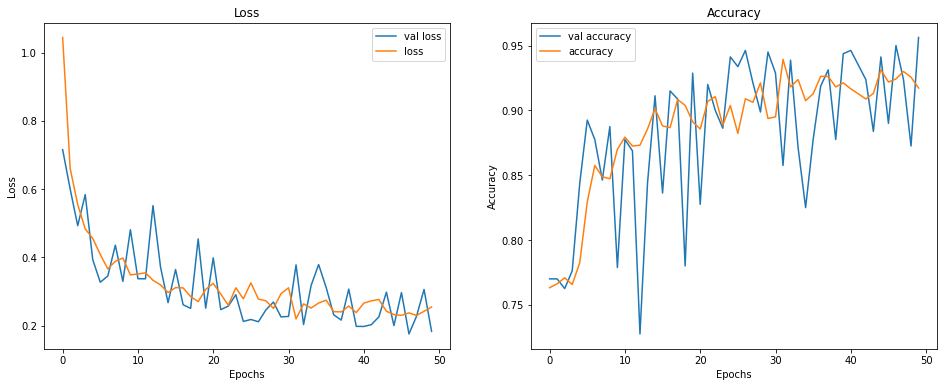

Test Accuracy = 0.41
Recall = 0.71


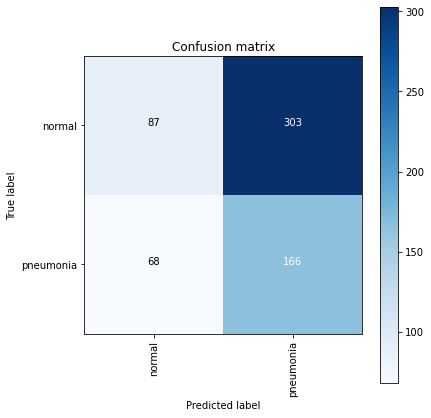

In [89]:
results_df = make_results(results_df,image_size,train_time,model_name,history_CNN9, model_CNN9, test_images_100_arg, test_y)
display(results_df)
plot_results(history_CNN9, model_CNN9, test_images_100_arg, test_y)

##### 12) Pre-trained Augmented CNN 100x100 frozen layer VGG16

In [97]:
model_name = "Pre-trained Augmented CNN 100x100 frozen layer VGG16"

base_model_cnn = VGG16(
        weights='imagenet',
        include_top=False, 
        input_shape=(100,100,3))
# Freeze VGG layer
base_model_cnn.trainable = False

In [98]:
model_new7 = models.Sequential()
model_new7.add(base_model_cnn)
model_new7.add(layers.Flatten())
model_new7.add(layers.Dense(1000, activation="relu", kernel_regularizer = l2(l2 = 0.01)))
model_new7.add(layers.Dropout(0.7))
model_new7.add(layers.Dense(1000, activation="relu", kernel_regularizer = l2(l2 = 0.01)))
model_new7.add(layers.Dropout(0.7))
model_new7.add(layers.Dense(300, activation="relu", kernel_regularizer = l2(l2 = 0.01)))
model_new7.add(layers.Dropout(0.6))
model_new7.add(layers.Dense(1,activation="sigmoid"))
model_new7.compile(
    loss='binary_crossentropy',
    optimizer="adam",
    metrics=['accuracy'])

In [99]:
start = time.time()
history__new7 = model_new7.fit_generator(train_generator_arg_100, 
                                steps_per_epoch=25, 
                                epochs=15, 
                                validation_data=val_generator_arg_100, 
                                validation_steps=25)
end = time.time()
train_time = round(end-start, 0)

Epoch 1/15
25/25 [==============================] - 170s 7s/step - loss: 19.3003 - accuracy: 0.6756 - val_loss: 10.7951 - val_accuracy: 0.7738
Epoch 2/15
25/25 [==============================] - 157s 6s/step - loss: 8.4687 - accuracy: 0.7525 - val_loss: 6.6021 - val_accuracy: 0.8275
Epoch 3/15
25/25 [==============================] - 139s 6s/step - loss: 5.5294 - accuracy: 0.8205 - val_loss: 4.6743 - val_accuracy: 0.8213
Epoch 4/15
25/25 [==============================] - 125s 5s/step - loss: 4.0327 - accuracy: 0.8838 - val_loss: 3.3960 - val_accuracy: 0.9350
Epoch 5/15
25/25 [==============================] - 121s 5s/step - loss: 3.1048 - accuracy: 0.8838 - val_loss: 2.6738 - val_accuracy: 0.9075
Epoch 6/15
25/25 [==============================] - 119s 5s/step - loss: 2.4374 - accuracy: 0.8962 - val_loss: 2.0667 - val_accuracy: 0.9287
Epoch 7/15
25/25 [==============================] - 134s 5s/step - loss: 1.9538 - accuracy: 0.8956 - val_loss: 1.6637 - val_accuracy: 0.9350
Epoch 8/15


In [100]:
model_new7.evaluate(test_images_100_arg, test_y)

20/20 [==============================] - 29s 1s/step - loss: 2.0771 - accuracy: 0.4359


[2.0770604610443115, 0.43589743971824646]

,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",615996,16.0,0.9573,0.9509,0.8237,0.5513
0,Baseline with reg,"(64, 64)",615996,26.0,0.9055,0.912,0.7404,0.3162
0,"Baseline with reg, dropout","(64, 64)",615996,25.0,0.8849,0.9166,0.7612,0.3718
0,"Baseline with reg, dropout, optimizer","(64, 64)",615996,27.0,0.8316,0.8274,0.6571,0.0855
0,"Baseline with reg, dropout, optimizer + extra ...","(64, 64)",615996,61.0,0.9464,0.9451,0.859,0.6624
0,Basic CNN,"(64, 64)",105279,552.0,0.9724,0.9509,0.8221,0.5513
0,Basic CNN with reg,"(64, 64)",128049,588.0,0.9796,0.9691,0.8878,0.7137
0,Basic CNN with reg,"(64, 64)",128049,588.0,0.9796,0.9691,0.8878,0.7137
0,Basic CNN 100x100,"(100, 100)",228159,1084.0,0.9726,0.9577,0.7965,0.4744
0,Basic CNN 100x100 with reg,"(100, 100)",227869,959.0,0.9651,0.9451,0.8702,0.6966


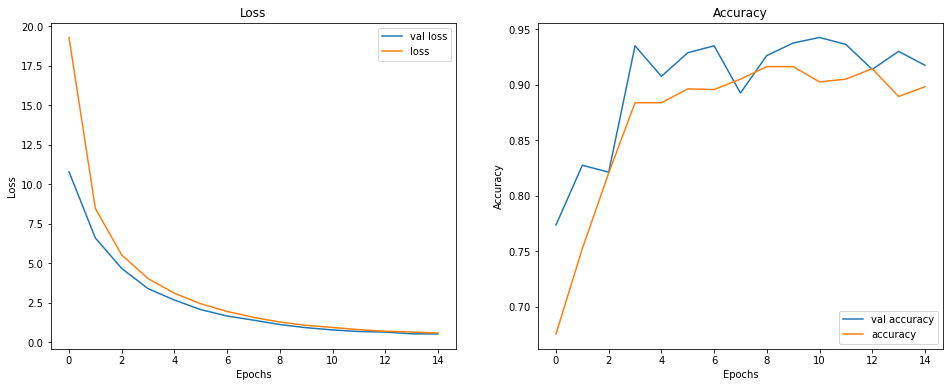

Test Accuracy = 0.44
Recall = 0.61


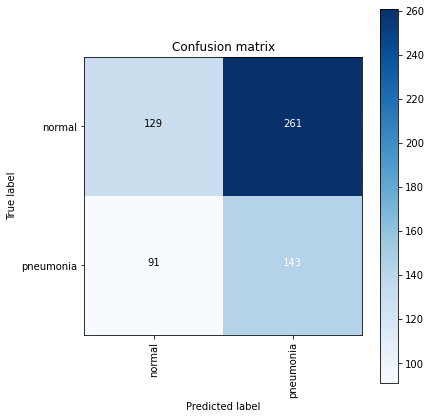

In [101]:
results_df = make_results(results_df,image_size,train_time,model_name,history__new7, model_new7, test_images_100_arg, test_y)
display(results_df)
plot_results(history__new7, model_new7, test_images_100_arg, test_y)

In [109]:
# train_datagen_arg_100 = ImageDataGenerator(rescale=1./255, 
#                                    rotation_range=20, 
#                                    width_shift_range=0.1, 
#                                    height_shift_range=0.1, 
#                                    shear_range=0.2, 
#                                    horizontal_flip=False)
# test_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
#         test_folder, 
#         target_size=(100, 100), 
#         batch_size = test_img_number,
#         class_mode='binary') 

# # get all the data in the directory split/validation, and reshape them
# val_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
#         val_folder, 
#         target_size=(100, 100),
#         batch_size = 32,
#         class_mode='binary',
#         shuffle = True)

# # get all the data in the directory split/train , and reshape them
# train_generator_arg_100 = train_datagen_arg_100.flow_from_directory(
#         train_folder, target_size=(100, 100),
#         batch_size = 64, class_mode='binary',
#         shuffle = True)


Found 624 images belonging to 2 classes.
Found 875 images belonging to 2 classes.
Found 4963 images belonging to 2 classes.


In [110]:
model_name = "2 Pre-trained Augmented CNN 100x100 frozen layer VGG16"

base_model_cnn = VGG16(
        weights='imagenet',
        include_top=False, 
        input_shape=(100,100,3))
# Freeze VGG layer
base_model_cnn.trainable = False

In [111]:
model_new6 = models.Sequential()
model_new6.add(base_model_cnn)
model_new6.add(layers.Flatten())
model_new6.add(layers.Dense(1000, activation="relu", kernel_regularizer = l2(l2 = 0.01)))
model_new6.add(layers.Dropout(0.7))
model_new6.add(layers.Dense(1000, activation="relu", kernel_regularizer = l2(l2 = 0.01)))
model_new6.add(layers.Dropout(0.7))
model_new6.add(layers.Dense(300, activation="relu", kernel_regularizer = l2(l2 = 0.01)))
model_new6.add(layers.Dropout(0.6))
model_new6.add(layers.Dense(1,activation="sigmoid"))
model_new6.compile(
    loss='binary_crossentropy',
    optimizer="adam",
    metrics=['accuracy'])

In [112]:
start = time.time()
history__new6 = model_new6.fit_generator(train_generator_arg_100, 
                                steps_per_epoch=25, 
                                epochs=5, 
                                validation_data=val_generator_arg_100, 
                                validation_steps=25)
end = time.time()
train_time = round(end-start, 0)

Epoch 1/5
25/25 [==============================] - 119s 5s/step - loss: 19.6524 - accuracy: 0.6725 - val_loss: 11.1462 - val_accuracy: 0.7650
Epoch 2/5
25/25 [==============================] - 133s 5s/step - loss: 8.8097 - accuracy: 0.7715 - val_loss: 7.0153 - val_accuracy: 0.8450
Epoch 3/5
25/25 [==============================] - 140s 6s/step - loss: 5.9456 - accuracy: 0.8425 - val_loss: 4.9330 - val_accuracy: 0.9337
Epoch 4/5
25/25 [==============================] - 123s 5s/step - loss: 4.4239 - accuracy: 0.8819 - val_loss: 3.8686 - val_accuracy: 0.8562
Epoch 5/5
25/25 [==============================] - 115s 5s/step - loss: 3.4221 - accuracy: 0.8969 - val_loss: 2.9521 - val_accuracy: 0.9375


,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",615996,16.0,0.9573,0.9509,0.8237,0.5513
0,Baseline with reg,"(64, 64)",615996,26.0,0.9055,0.912,0.7404,0.3162
0,"Baseline with reg, dropout","(64, 64)",615996,25.0,0.8849,0.9166,0.7612,0.3718
0,"Baseline with reg, dropout, optimizer","(64, 64)",615996,27.0,0.8316,0.8274,0.6571,0.0855
0,"Baseline with reg, dropout, optimizer + extra ...","(64, 64)",615996,61.0,0.9464,0.9451,0.859,0.6624
0,Basic CNN,"(64, 64)",105279,552.0,0.9724,0.9509,0.8221,0.5513
0,Basic CNN with reg,"(64, 64)",128049,588.0,0.9796,0.9691,0.8878,0.7137
0,Basic CNN with reg,"(64, 64)",128049,588.0,0.9796,0.9691,0.8878,0.7137
0,Basic CNN 100x100,"(100, 100)",228159,1084.0,0.9726,0.9577,0.7965,0.4744
0,Basic CNN 100x100 with reg,"(100, 100)",227869,959.0,0.9651,0.9451,0.8702,0.6966


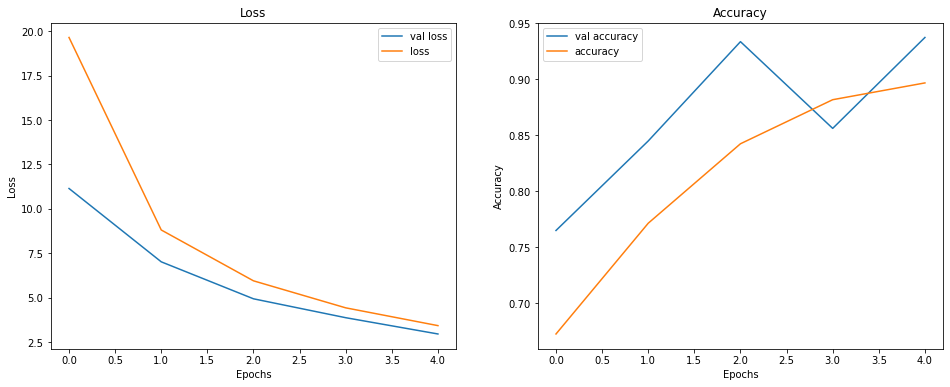

Test Accuracy = 0.43
Recall = 0.68


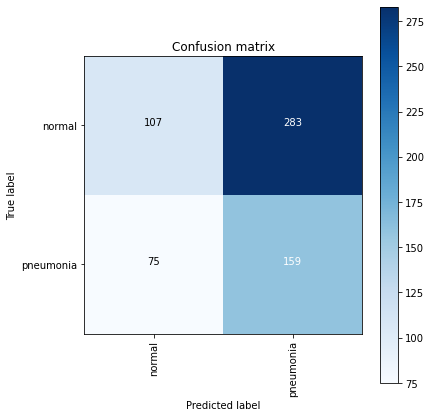

In [113]:
results_df = make_results(results_df,image_size,train_time,model_name,history__new6, model_new6, test_images_100_arg, test_y)
display(results_df)
plot_results(history__new6, model_new6, test_images_100_arg, test_y)

Found 624 images belonging to 2 classes.
Found 875 images belonging to 2 classes.
Found 4963 images belonging to 2 classes.
Epoch 1/10
25/25 [==============================] - 211s 8s/step - loss: 19.1932 - accuracy: 0.6977 - val_loss: 10.6345 - val_accuracy: 0.7912
Epoch 2/10
25/25 [==============================] - 193s 8s/step - loss: 7.8570 - accuracy: 0.7863 - val_loss: 5.7708 - val_accuracy: 0.9187
Epoch 3/10
25/25 [==============================] - 182s 7s/step - loss: 4.7273 - accuracy: 0.8440 - val_loss: 3.7283 - val_accuracy: 0.9162
Epoch 4/10
25/25 [==============================] - 181s 7s/step - loss: 3.2230 - accuracy: 0.8642 - val_loss: 2.6815 - val_accuracy: 0.8650
Epoch 5/10
25/25 [==============================] - 183s 7s/step - loss: 2.3142 - accuracy: 0.8713 - val_loss: 1.8871 - val_accuracy: 0.9250
Epoch 6/10
25/25 [==============================] - 183s 7s/step - loss: 1.7192 - accuracy: 0.8793 - val_loss: 1.3949 - val_accuracy: 0.9312
Epoch 7/10
25/25 [==========

,Model name,Image size,Parameters,Train time,Train accuracy,Validation accuracy,Test accuracy,Test Recall
0,Baseline_model,"(64, 64)",615996,16.0,0.9573,0.9509,0.8237,0.5513
0,Baseline with reg,"(64, 64)",615996,26.0,0.9055,0.912,0.7404,0.3162
0,"Baseline with reg, dropout","(64, 64)",615996,25.0,0.8849,0.9166,0.7612,0.3718
0,"Baseline with reg, dropout, optimizer","(64, 64)",615996,27.0,0.8316,0.8274,0.6571,0.0855
0,"Baseline with reg, dropout, optimizer + extra ...","(64, 64)",615996,61.0,0.9464,0.9451,0.859,0.6624
0,Basic CNN,"(64, 64)",105279,552.0,0.9724,0.9509,0.8221,0.5513
0,Basic CNN with reg,"(64, 64)",128049,588.0,0.9796,0.9691,0.8878,0.7137
0,Basic CNN with reg,"(64, 64)",128049,588.0,0.9796,0.9691,0.8878,0.7137
0,Basic CNN 100x100,"(100, 100)",228159,1084.0,0.9726,0.9577,0.7965,0.4744
0,Basic CNN 100x100 with reg,"(100, 100)",227869,959.0,0.9651,0.9451,0.8702,0.6966


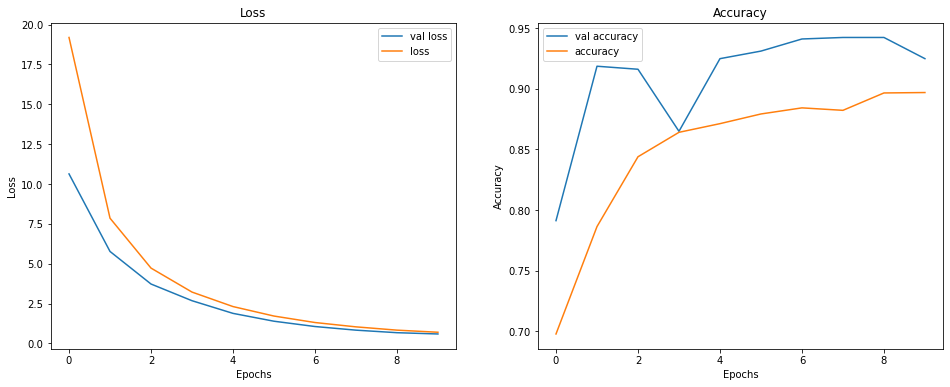

Test Accuracy = 0.91
Recall = 0.96


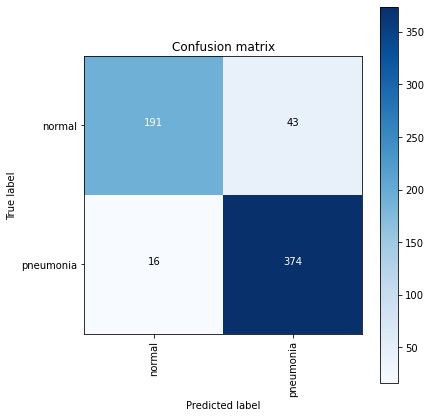

In [129]:
train_datagen_arg_100 = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=20, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   vertical_flip=True)
test_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(100, 100), 
        batch_size = test_img_number,
        class_mode='binary') 

# get all the data in the directory split/validation, and reshape them
val_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(100, 100),
        batch_size = 32,
        class_mode='binary',
        shuffle = True)

# get all the data in the directory split/train , and reshape them
train_generator_arg_100 = train_datagen_arg_100.flow_from_directory(
        train_folder, target_size=(100, 100),
        batch_size = 120, class_mode='binary',
        shuffle = True)
test_images, test_labels = next(test_generator_arg_100)
test_y = np.reshape(test_labels[:,], (test_img_number,1))


model_name = "Pre-trained Augmented CNN 100x100 frozen layer VGG16"

base_model_cnn = VGG16(
        weights='imagenet',
        include_top=False, 
        input_shape=(100,100,3))
# Freeze VGG layer
base_model_cnn.trainable = False

model_new6 = models.Sequential()
model_new6.add(base_model_cnn)
model_new6.add(layers.Flatten())
model_new6.add(layers.Dense(1000, activation="relu", kernel_regularizer = l2(l2 = 0.01)))
model_new6.add(layers.Dropout(0.7))
model_new6.add(layers.Dense(1000, activation="relu", kernel_regularizer = l2(l2 = 0.01)))
model_new6.add(layers.Dropout(0.7))
model_new6.add(layers.Dense(300, activation="relu", kernel_regularizer = l2(l2 = 0.01)))
model_new6.add(layers.Dropout(0.6))
model_new6.add(layers.Dense(1,activation="sigmoid"))
model_new6.compile(
    loss='binary_crossentropy',
    optimizer="adam",
    metrics=['accuracy'])

start = time.time()
history__new6 = model_new6.fit_generator(train_generator_arg_100, 
                                steps_per_epoch=25, 
                                epochs=10, 
                                validation_data=val_generator_arg_100, 
                                validation_steps=25)
end = time.time()
train_time = round(end-start, 0)

results_df = make_results(results_df,image_size,train_time,model_name,history__new6, model_new6, test_images, test_y)
display(results_df)
plot_results(history__new6, model_new6, test_images, test_y)

In [ ]:
# test shift range to 0.2 , vertical flip = true, shuffle = true, epoch = 5, 64/32 batches -  0.4295	0.7479

In [ ]:
# test shift range to 0.2 , vertical flip = true, shuffle = true,epoch = 12, 64/32 batches : 0.899	0.9564

In [ ]:
# test shift range to 0.2 , vertical flip = true, shuffle = true,epoch = 20, 64/32 batches -  0.8734	0.971

In [ ]:
# test shift range to 0.2 , vertical flip = true, shuffle = true,epoch = 10, 64/32 batches -   0.8381 0.9846

In [ ]:
# test shift range to 0.2 , vertical flip = true, shuffle = true,epoch = 10, 96/32 batches -    0.8894	0.9564

In [ ]:
# test shift range to 0.2 , vertical flip = true, shuffle = true,epoch = 10, 120/32 batches -    0.9054	0.959

##### 12) Pre-trained Augmented CNN 200x200 frozen layer VGG16


In [ ]:
image_size = (200,200)
train_datagen_arg_100 = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=20, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   vertical_flip=True)
test_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=image_size, 
        batch_size = test_img_number,
        class_mode='binary') 

# get all the data in the directory split/validation, and reshape them
val_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=image_size,
        batch_size = 32,
        class_mode='binary',
        shuffle = True)

# get all the data in the directory split/train , and reshape them
train_generator_arg_100 = train_datagen_arg_100.flow_from_directory(
        train_folder, target_size=image_size,
        batch_size = 120, class_mode='binary',
        shuffle = True)
test_images, test_labels = next(test_generator_arg_100)
test_y = np.reshape(test_labels[:,], (test_img_number,1))


model_name = "Pre-trained Augmented CNN 200x200 frozen layer VGG16"

base_model_cnn = VGG16(
        weights='imagenet',
        include_top=False, 
        input_shape=(200,200,3))
# Freeze VGG layer
base_model_cnn.trainable = False

model_new5 = models.Sequential()
model_new5.add(base_model_cnn)
model_new5.add(layers.Flatten())
model_new5.add(layers.Dense(1000, activation="relu", kernel_regularizer = l2(l2 = 0.01)))
model_new5.add(layers.Dropout(0.7))
model_new5.add(layers.Dense(1000, activation="relu", kernel_regularizer = l2(l2 = 0.01)))
model_new5.add(layers.Dropout(0.7))
model_new5.add(layers.Dense(300, activation="relu", kernel_regularizer = l2(l2 = 0.01)))
model_new5.add(layers.Dropout(0.6))
model_new5.add(layers.Dense(1,activation="sigmoid"))
model_new5.compile(
    loss='binary_crossentropy',
    optimizer="adam",
    metrics=['accuracy'])

start = time.time()
history__new5 = model_new5.fit_generator(train_generator_arg_100, 
                                steps_per_epoch=25, 
                                epochs=10, 
                                validation_data=val_generator_arg_100, 
                                validation_steps=25)
end = time.time()
train_time = round(end-start, 0)

results_df = make_results(results_df,image_size,train_time,model_name,history__new5, model_new5, test_images, test_y)
display(results_df)
plot_results(history__new5, model_new5, test_images, test_y)

Found 624 images belonging to 2 classes.
Found 875 images belonging to 2 classes.
Found 4963 images belonging to 2 classes.
Epoch 1/10
25/25 [==============================] - 644s 26s/step - loss: 19.5639 - accuracy: 0.6599 - val_loss: 11.8823 - val_accuracy: 0.8188
Epoch 2/10
25/25 [==============================] - 735s 29s/step - loss: 9.5761 - accuracy: 0.7623 - val_loss: 7.6174 - val_accuracy: 0.9112
Epoch 3/10
25/25 [==============================] - 673s 27s/step - loss: 6.5688 - accuracy: 0.8406 - val_loss: 5.6306 - val_accuracy: 0.9162
Epoch 4/10
25/25 [==============================] - 714s 29s/step - loss: 5.1260 - accuracy: 0.8437 - val_loss: 4.5320 - val_accuracy: 0.9250
Epoch 5/10
25/25 [==============================] - 736s 30s/step - loss: 4.1697 - accuracy: 0.8652 - val_loss: 3.7065 - val_accuracy: 0.9250
Epoch 6/10
25/25 [==============================] - 660s 26s/step - loss: 3.4774 - accuracy: 0.8744 - val_loss: 3.1132 - val_accuracy: 0.9300
Epoch 7/10
25/25 [====

In [ ]:
# 200x200 test shift range to 0.2 , vertical flip = true, shuffle = true,epoch = 10, 120/32 batches -

In [ ]:
# train_datagen_arg_100 = ImageDataGenerator(rescale=1./255, 
#                                    rotation_range=20, 
#                                    width_shift_range=0.2, 
#                                    height_shift_range=0.2, 
#                                    shear_range=0.2, 
#                                    vertical_flip=True)
# test_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
#         test_folder, 
#         target_size=(100, 100), 
#         batch_size = test_img_number,
#         class_mode='binary') 

# # get all the data in the directory split/validation, and reshape them
# val_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
#         val_folder, 
#         target_size=(100, 100),
#         batch_size = 32,
#         class_mode='binary',
#         shuffle = True)

# # get all the data in the directory split/train , and reshape them
# train_generator_arg_100 = train_datagen_arg_100.flow_from_directory(
#         train_folder, target_size=(100, 100),
#         batch_size = 64, class_mode='binary',
#         shuffle = True)
# test_images, test_labels = next(test_generator_arg_100)
# test_y = np.reshape(test_labels[:,], (test_img_number,1))


# model_name = "2 Pre-trained Augmented CNN 100x100 frozen layer VGG16"

# base_model_cnn = VGG16(
#         weights='imagenet',
#         include_top=False, 
#         input_shape=(100,100,3))
# # Freeze VGG layer
# base_model_cnn.trainable = False

# model_new6 = models.Sequential()
# model_new6.add(base_model_cnn)
# model_new6.add(layers.Flatten())
# model_new6.add(layers.Dense(1000, activation="relu", kernel_regularizer = l2(l2 = 0.01)))
# model_new6.add(layers.Dropout(0.7))
# model_new6.add(layers.Dense(1000, activation="relu", kernel_regularizer = l2(l2 = 0.01)))
# model_new6.add(layers.Dropout(0.7))
# model_new6.add(layers.Dense(300, activation="relu", kernel_regularizer = l2(l2 = 0.01)))
# model_new6.add(layers.Dropout(0.6))
# model_new6.add(layers.Dense(1,activation="sigmoid"))
# model_new6.compile(
#     loss='binary_crossentropy',
#     optimizer="adam",
#     metrics=['accuracy'])

# start = time.time()
# history__new6 = model_new6.fit_generator(train_generator_arg_100, 
#                                 steps_per_epoch=25, 
#                                 epochs=12, 
#                                 validation_data=val_generator_arg_100, 
#                                 validation_steps=25)
# end = time.time()
# train_time = round(end-start, 0)

# results_df = make_results(results_df,image_size,train_time,model_name,history__new6, model_new6, test_images, test_y)
# display(results_df)
# plot_results(history__new6, model_new6, test_images, test_y)

##### Fine tuning
`

In [ ]:
# Define best model
best_model = 
test_images_in_resolution =
test_images_labels = 
predictions = best_model.predict(test_images_in_resolution)
predictions_base = [1 if x > 0.5 else 0 for x in predictions]
test_accuracy_base = round(accuracy_score(test_images_labels, predictions_base),4)
test_recall_base = round(recall_score(test_images_labels, predictions_base),4)

In [ ]:
# Loop with changing prediction bondaries
list_of_thresholds = list(range(0.2, 0.81, 0.05))
list_of_options=[]
for threshold in list_of_thresholds:
    prediction_new = [1 if x > threshold else 0 for x in predictions]
    test_accuracy = round(accuracy_score(test_images_labels, prediction_new),4)
    test_recall = round(recall_score(test_images_labels, prediction_new),4)
    list_of_options.append((threshold, test_accuracy, test_recall))
    

In [ ]:
# Base model predictions
print("Optimization focusen on accuracy")
print(f"Model accuracy{test_accuracy_base}. Model recall {test_recall_base}")


# Best prediction threshold for accuracy
threshold_acc = sorted(list_of_options, key = lambda x: x[1], reverse = True)[0]
print("Optimization focusen on accuracy")
print(f"Model accuracy{threshold_acc[1]}. Model recall {threshold_acc[2]}")


# Best prediction threshold for recall
threshold_recall = sorted(list_of_options, key = lambda x: x[2], reverse = True)[0]
print("Optimization focusen on recall")
print(f"Model accuracy{threshold_recall[1]}. Model recall {threshold_recall[2]}")



In [ ]:
# Dubious cases removal
lower_border = 0.4
upper_border = 0.6
new_list = zip (test_images_labels, predictions)
new_predictions = [item for item in new_list if ((item[1] > upper_border) or (item[1] < lower_border))]
new_test_set = [new_prediction[0] for new_prediction in new_predictions]
new_predictions_after = [1 if x[1] > 0.5 else 0 for x in new_predictions]
new_accuracy = round(accuracy_score(new_test_set, new_predictions_after),4)
new_recall = round(recall_score(new_test_set, new_predictions_after),4)
print(f"Doubious cases investigation:")
print(f"Doubious cases that were removed:{round((1-len(new_predictions)/len(predictions))*100,4)}%")
print(f"Model accuracy after removal{new_accuracy}. Model recall after removal{new_recall}")


# Conclusion
---
Based on results our finall model will be: 

With the following parameters:

Because of the following reasons: 
1) It satisfy requirements on recall.

2) It has high accuracy. 

Further accuracy improvement might not be possible due to human factor(qualit of materials and bias based on it) 

Overall, this data tells us that current X-ray have enought information so we can be sure that each patient will be treated well. 